## Importing Libraries & Dependencies

In [1]:
!pip install pandasql

In [5]:
!pip install Orange3


In [7]:
!pip install Orange3-Associate


     ---------------------------------------- 0.0/505.5 kB ? eta -:--:--
     ---- ---------------------------------- 61.4/505.5 kB 3.4 MB/s eta 0:00:01
     -------------------------------------  501.8/505.5 kB 5.3 MB/s eta 0:00:01
     -------------------------------------- 505.5/505.5 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for Orange3-Associate: filename=Orange3_Associate-1.3.0-py3-none-any.whl size=47568 sha256=5858b4f4a365f8f9b11355348d5c9c210f623aa917da54bd9dc71da4a8ae4f37
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\bf\6c\79\0e70cf062306a88090a8ff1eab92fb6796c61382ecddeb796d
Successfully built Orange3-Associate


In [8]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

In [11]:
cs_df = pd.read_excel('Online Retail.xlsx')

## Exploratory Data Analysis


In [13]:
def rstr(df, pred='target'):
    # Filter for only numeric columns to avoid datetime or categorical columns
    numeric_df = df.select_dtypes(include=['number'])

    obs = df.shape[0]
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum() / obs) * 100
    skewness = numeric_df.skew()
    kurtosis = numeric_df.kurt()

    print('Data shape:', df.shape)
    print('Numeric Columns Skewness:\n', skewness)
    print('Numeric Columns Kurtosis:\n', kurtosis)
    print('Missing Ratio (%):\n', missing_ration)
    print('Distinct Values:\n', distincts)
    print('___________________________')

    return pd.DataFrame({'missing ration': missing_ration, 'distincts': distincts, 'skewness': skewness, 'kurtosis': kurtosis})

# Run the function
details = rstr(cs_df)
display(details.sort_values(by='missing ration', ascending=False))


Data shape: (541909, 8)
Numeric Columns Skewness:
 Quantity       -0.264076
UnitPrice     186.506972
CustomerID      0.029835
dtype: float64
Numeric Columns Kurtosis:
 Quantity      119769.160031
UnitPrice      59005.719097
CustomerID        -1.179982
dtype: float64
Missing Ratio (%):
 InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64
Distinct Values:
 InvoiceNo      25900
StockCode       4070
Description     4224
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4373
Country           38
dtype: int64
___________________________


missing ration  distincts    skewness       kurtosis
CustomerID        24.926694       4373    0.029835      -1.179982
Description        0.268311       4224         NaN            NaN
Country            0.000000         38         NaN            NaN
InvoiceDate        0.000000      23260         NaN            NaN
InvoiceNo          0.000000      25900         NaN            NaN
Quantity           0.000000        722   -0.264076  119769.160031
StockCode          0.000000       4070         NaN            NaN
UnitPrice          0.000000       1630  186.506972   59005.719097

In [15]:
cs_df.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303

In [17]:
print('Check if we had negative quantity and prices at same register:',
     'No' if cs_df[(cs_df.Quantity<0) & (cs_df.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')
print('Check how many register we have where quantity is negative',
      'and prices is 0 or vice-versa:',
      cs_df[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0)].shape[0])
print('\nWhat is the customer ID of the registers above:',
      cs_df.loc[(cs_df.Quantity<=0) & (cs_df.UnitPrice<=0),
                ['CustomerID']].CustomerID.unique())
print('\n% Negative Quantity: {:3.2%}'.format(cs_df[(cs_df.Quantity<0)].shape[0]/cs_df.shape[0]))
print('\nAll register with negative quantity has Invoice start with:',
      cs_df.loc[(cs_df.Quantity<0) & ~(cs_df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())
print('\nSee an example of negative quantity and others related records:')
display(cs_df[(cs_df.CustomerID==12472) & (cs_df.StockCode==22244)])

Check if we had negative quantity and prices at same register: No 

Check how many register we have where quantity is negative and prices is 0 or vice-versa: 1336

What is the customer ID of the registers above: [nan]

% Negative Quantity: 1.96%

All register with negative quantity has Invoice start with: ['C']

See an example of negative quantity and others related records:


InvoiceNo StockCode                 Description  Quantity  \
1973     C536548     22244  3 HOOK HANGER MAGIC GARDEN        -4   
9438      537201     22244  3 HOOK HANGER MAGIC GARDEN        12   
121980    546843     22244  3 HOOK HANGER MAGIC GARDEN        12   

               InvoiceDate  UnitPrice  CustomerID  Country  
1973   2010-12-01 14:33:00       1.95     12472.0  Germany  
9438   2010-12-05 14:19:00       1.95     12472.0  Germany  
121980 2011-03-17 12:40:00       1.95     12472.0  Germany

In [19]:
print('Check register with UnitPrice negative:')
display(cs_df[(cs_df.UnitPrice<0)])
print("Sales records with Customer ID and zero in Unit Price:",cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())].shape[0])
cs_df[(cs_df.UnitPrice==0)  & ~(cs_df.CustomerID.isnull())]

Check register with UnitPrice negative:


InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

Sales records with Customer ID and zero in Unit Price: 40


InvoiceNo StockCode                          Description  Quantity  \
9302      537197     22841         ROUND CAKE TIN VINTAGE GREEN         1   
33576     539263     22580         ADVENT CALENDAR GINGHAM SACK         4   
40089     539722     22423             REGENCY CAKESTAND 3 TIER        10   
47068     540372     22090              PAPER BUNTING RETROSPOT        24   
47070     540372     22553               PLASTERS IN TIN SKULLS        24   
56674     541109     22168        ORGANISER WOOD ANTIQUE WHITE          1   
86789     543599    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        16   
130188    547417     22062  CERAMIC BOWL WITH LOVE HEART DESIGN        36   
139453    548318     22055   MINI CAKE STAND  HANGING STRAWBERY         5   
145208    548871     22162          HEART GARLAND RUSTIC PADDED         2   
157042    550188     22636   CHILDS BREAKFAST SET CIRCUS PARADE         1   
187613    553000     47566                        PARTY BUNTING         4   
198383    554037     22619            SET OF 6 SOLDIER SKITTLES        80   
279324    561284     22167           OVAL WALL MIRROR DIAMANTE          1   
282912    561669     22960             JAM MAKING SET WITH JARS        11   
285657    561916         M                               Manual         1   
298054    562973     23157           SET OF 6 NATIVITY MAGNETS        240   
314745    564651     23270     SET OF 2 CERAMIC PAINTED HEARTS         96   
314746    564651     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER       192   
314747    564651     22955             36 FOIL STAR CAKE CASES        144   
314748    564651     21786                   POLKADOT RAIN HAT        144   
358655    568158      PADS           PADS TO MATCH ALL CUSHIONS         1   
361825    568384         M                               Manual         1   
379913    569716     22778                   GLASS CLOCHE SMALL         2   
395529    571035         M                               Manual         1   
420404    572893     21208          PASTEL COLOUR HONEYCOMB FAN         5   
436428    574138     23234        BISCUIT TIN VINTAGE CHRISTMAS       216   
436597    574175     22065       CHRISTMAS PUDDING TRINKET POT         12   
436961    574252         M                               Manual         1   
439361    574469     22385            JUMBO BAG SPACEBOY DESIGN        12   
446125    574879     22625                   RED KITCHEN SCALES         2   
446793    574920     22899         CHILDREN'S APRON DOLLY GIRL          1   
446794    574920     23480       MINI LIGHTS WOODLAND MUSHROOMS         1   
454463    575579     22437        SET OF 9 BLACK SKULL BALLOONS        20   
454464    575579     22089        PAPER BUNTING VINTAGE PAISLEY        24   
479079    577129     22464          HANGING METAL HEART LANTERN         4   
479546    577168         M                               Manual         1   
480649    577314     23407       SET OF 2 TRAYS HOME SWEET HOME         2   
485985    577696         M                               Manual         1   
502122    578841     84826       ASSTD DESIGN 3D PAPER STICKERS     12540   

               InvoiceDate  UnitPrice  CustomerID         Country  
9302   2010-12-05 14:02:00        0.0     12647.0         Germany  
33576  2010-12-16 14:36:00        0.0     16560.0  United Kingdom  
40089  2010-12-21 13:45:00        0.0     14911.0            EIRE  
47068  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
47070  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
56674  2011-01-13 15:10:00        0.0     15107.0  United Kingdom  
86789  2011-02-10 13:08:00        0.0     17560.0  United Kingdom  
130188 2011-03-23 10:25:00        0.0     13239.0  United Kingdom  
139453 2011-03-30 12:45:00        0.0     13113.0  United Kingdom  
145208 2011-04-04 14:42:00        0.0     14410.0  United Kingdom  
157042 2011-04-14 18:57:00        0.0     12457.0     Switzerland  
187613 2011-05-12 15:21:00       

In [21]:
# Remove register withou CustomerID
cs_df = cs_df[~(cs_df.CustomerID.isnull())]

# Remove negative or return transactions
cs_df = cs_df[~(cs_df.Quantity<0)]
cs_df = cs_df[cs_df.UnitPrice>0]

details = rstr(cs_df)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (397884, 8)
Numeric Columns Skewness:
 Quantity      409.892972
UnitPrice     204.032727
CustomerID      0.025729
dtype: float64
Numeric Columns Kurtosis:
 Quantity      178186.243253
UnitPrice      58140.396673
CustomerID        -1.180822
dtype: float64
Missing Ratio (%):
 InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64
Distinct Values:
 InvoiceNo      18532
StockCode       3665
Description     3877
Quantity         301
InvoiceDate    17282
UnitPrice        440
CustomerID      4338
Country           37
dtype: int64
___________________________


missing ration  distincts    skewness       kurtosis
InvoiceNo               0.0      18532         NaN            NaN
InvoiceDate             0.0      17282         NaN            NaN
CustomerID              0.0       4338    0.025729      -1.180822
Description             0.0       3877         NaN            NaN
StockCode               0.0       3665         NaN            NaN
UnitPrice               0.0        440  204.032727   58140.396673
Quantity                0.0        301  409.892972  178186.243253
Country                 0.0         37         NaN            NaN

In [22]:
# Step 1: Count occurrences by "StockCode" and reset index
cat_des_df = cs_df.groupby(["StockCode", "Description"]).count().reset_index()

# Step 2: Find StockCodes with multiple occurrences and reset the index to check structure
repeated_stockcodes = cat_des_df['StockCode'].value_counts()
repeated_stockcodes_df = repeated_stockcodes[repeated_stockcodes > 1].reset_index()
repeated_stockcodes_df.columns = ['StockCode', 'count']  # Rename columns for clarity

# Display the structure to confirm
display(repeated_stockcodes_df.head())

# Step 3: Access the Description for a specific StockCode with multiple occurrences
# Access the StockCode directly by row number (e.g., 4th row)
target_stockcode = repeated_stockcodes_df.iloc[4]['StockCode']  # Get the fifth StockCode with multiple entries

# Filter the main DataFrame for this StockCode
filtered_descriptions = cs_df[cs_df['StockCode'] == target_stockcode]['Description'].unique()

# Display the result
print(filtered_descriptions)


StockCode  count
0     23196      4
1     23236      4
2     23203      3
3    17107D      3
4     23535      3

['BICYCLE SAFTEY WALL ART' 'WALL ART BICYCLE SAFTEY '
 'WALL ART BICYCLE SAFETY']


In [23]:
unique_desc = cs_df[["StockCode", "Description"]].groupby(by=["StockCode"]).\
                apply(pd.DataFrame.mode).reset_index(drop=True)
q = '''
select df.InvoiceNo, df.StockCode, un.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Country
from cs_df as df INNER JOIN
     unique_desc as un on df.StockCode = un.StockCode
'''

cs_df = pysqldf(q)

In [25]:
cs_df.InvoiceDate = pd.to_datetime(cs_df.InvoiceDate)
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice
cs_df.CustomerID = cs_df.CustomerID.astype('Int64')

details = rstr(cs_df)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (397884, 9)
Numeric Columns Skewness:
 InvoiceNo      -0.178524
Quantity      409.892972
UnitPrice     204.032727
CustomerID      0.025729
amount        451.443182
dtype: Float64
Numeric Columns Kurtosis:
 InvoiceNo         -1.200748
Quantity      178186.243253
UnitPrice      58140.396673
CustomerID        -1.180822
amount        232155.117219
dtype: Float64
Missing Ratio (%):
 InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
amount         0.0
dtype: float64
Distinct Values:
 InvoiceNo      18532
StockCode       3665
Description     3647
Quantity         301
InvoiceDate    17282
UnitPrice        440
CustomerID      4338
Country           37
amount          2939
dtype: int64
___________________________


missing ration  distincts    skewness       kurtosis
InvoiceNo               0.0      18532   -0.178524      -1.200748
InvoiceDate             0.0      17282        <NA>           <NA>
CustomerID              0.0       4338    0.025729      -1.180822
StockCode               0.0       3665        <NA>           <NA>
Description             0.0       3647        <NA>           <NA>
amount                  0.0       2939  451.443182  232155.117219
UnitPrice               0.0        440  204.032727   58140.396673
Quantity                0.0        301  409.892972  178186.243253
Country                 0.0         37        <NA>           <NA>

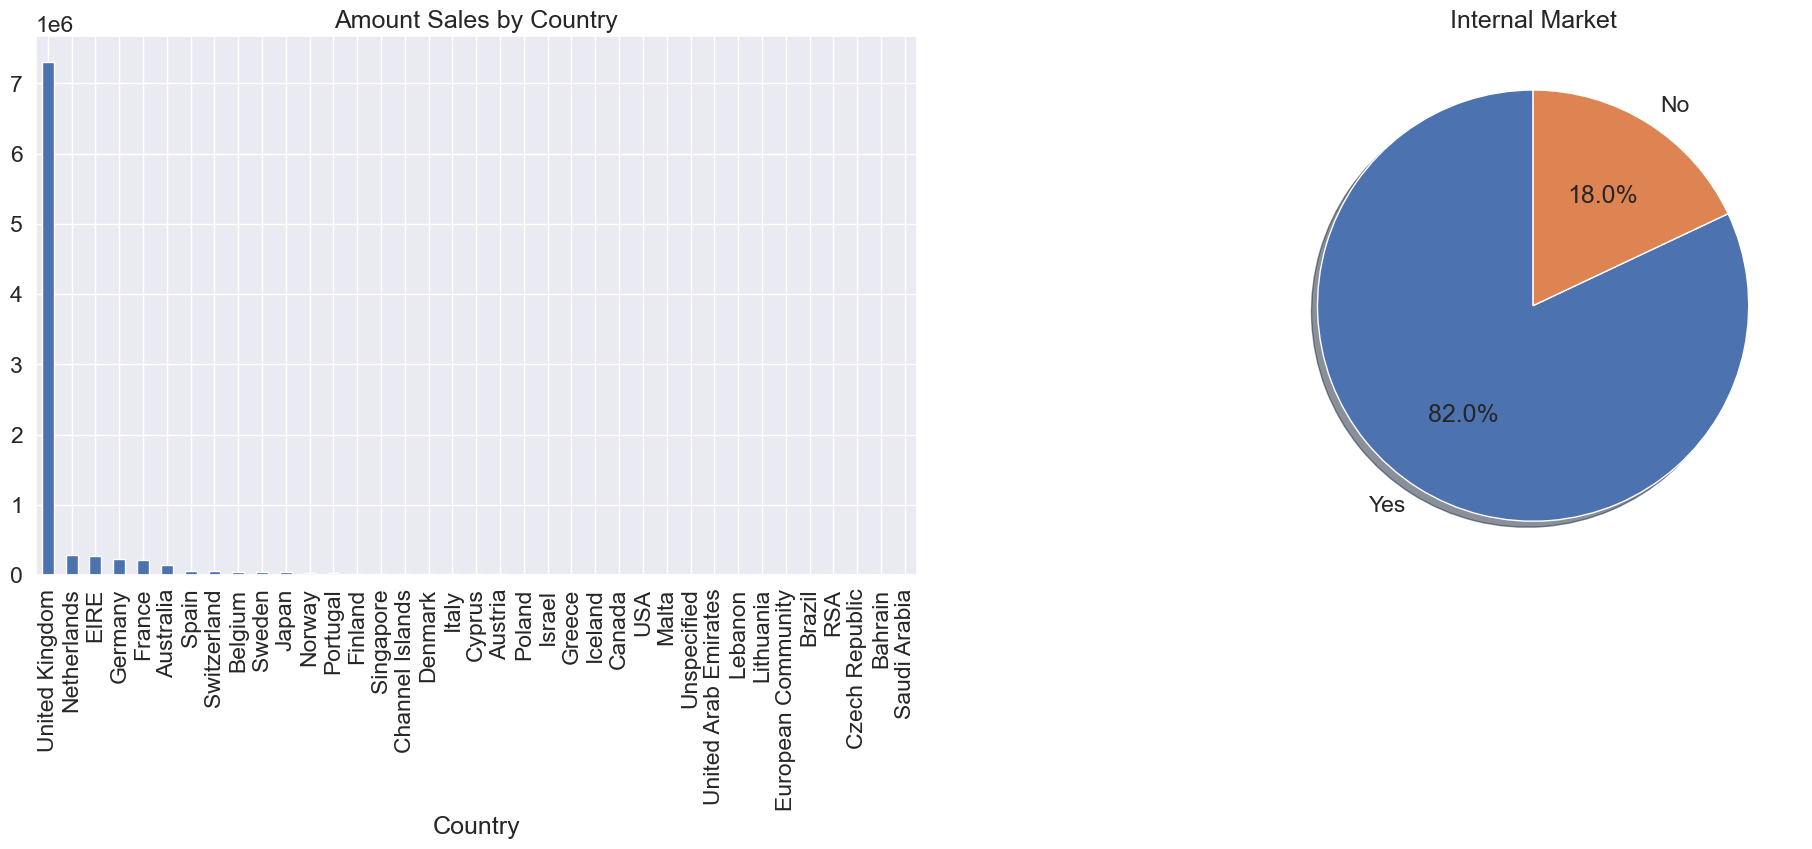

In [29]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = cs_df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
cs_df['Internal'] = cs_df.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = cs_df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()

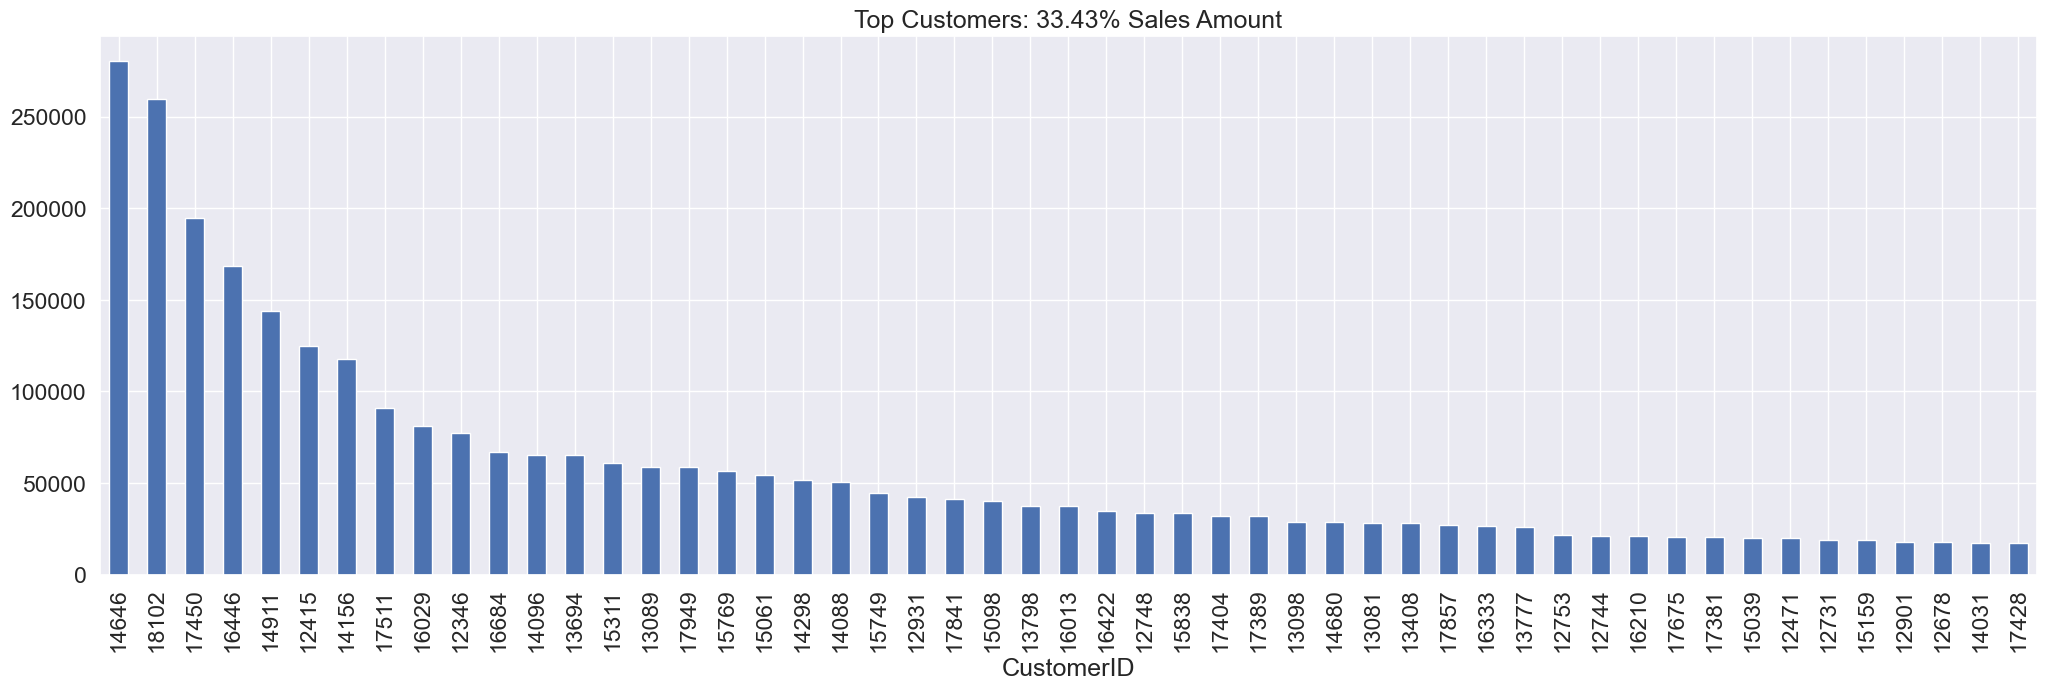

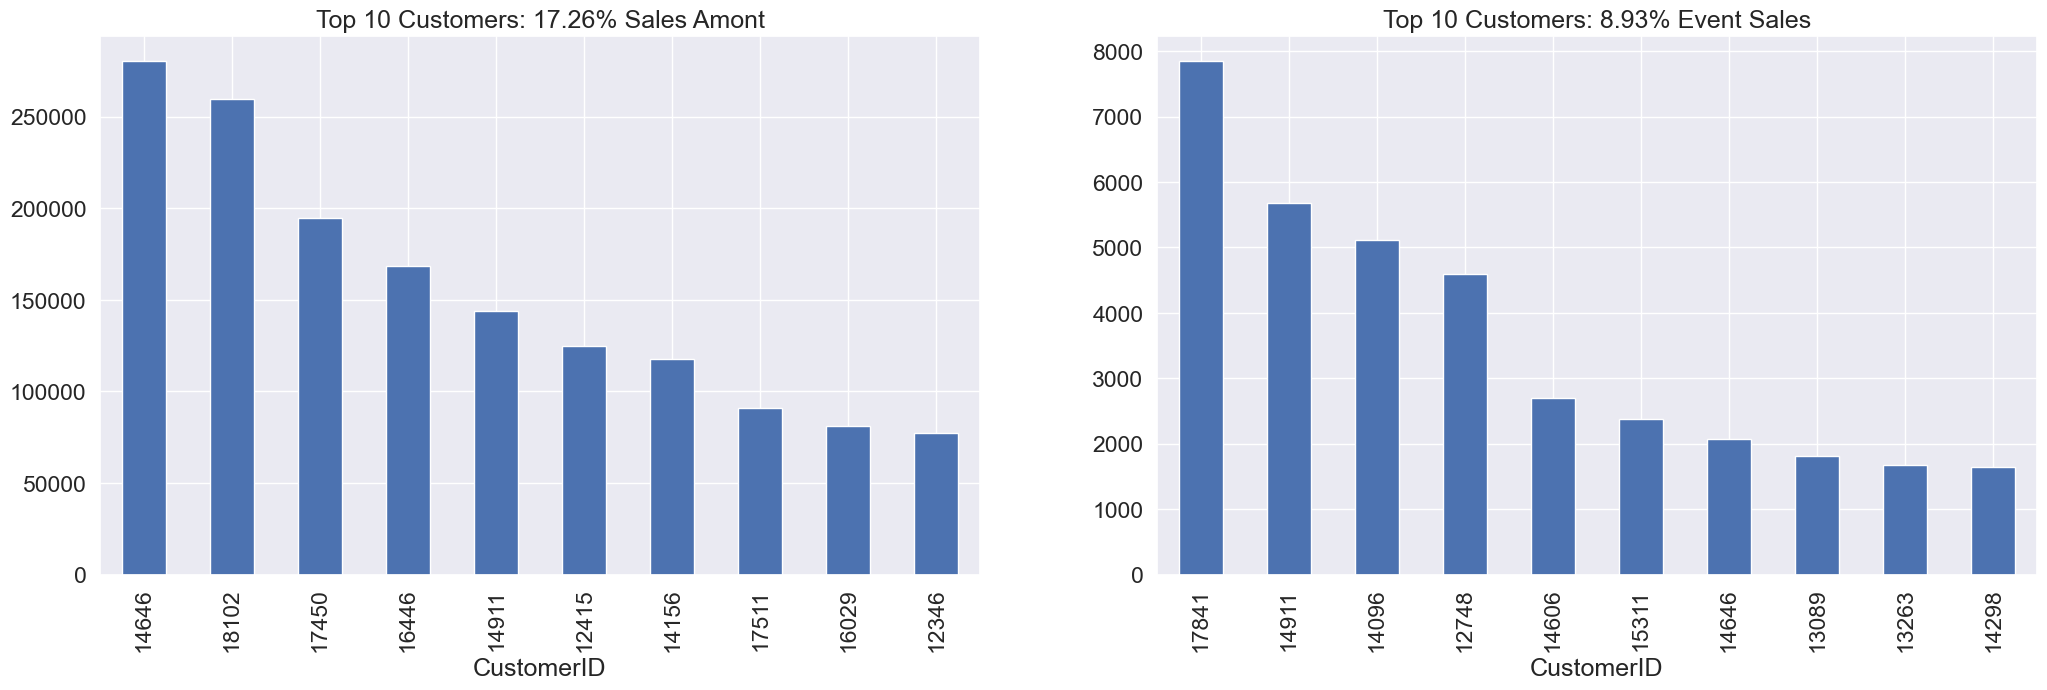

In [31]:
fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

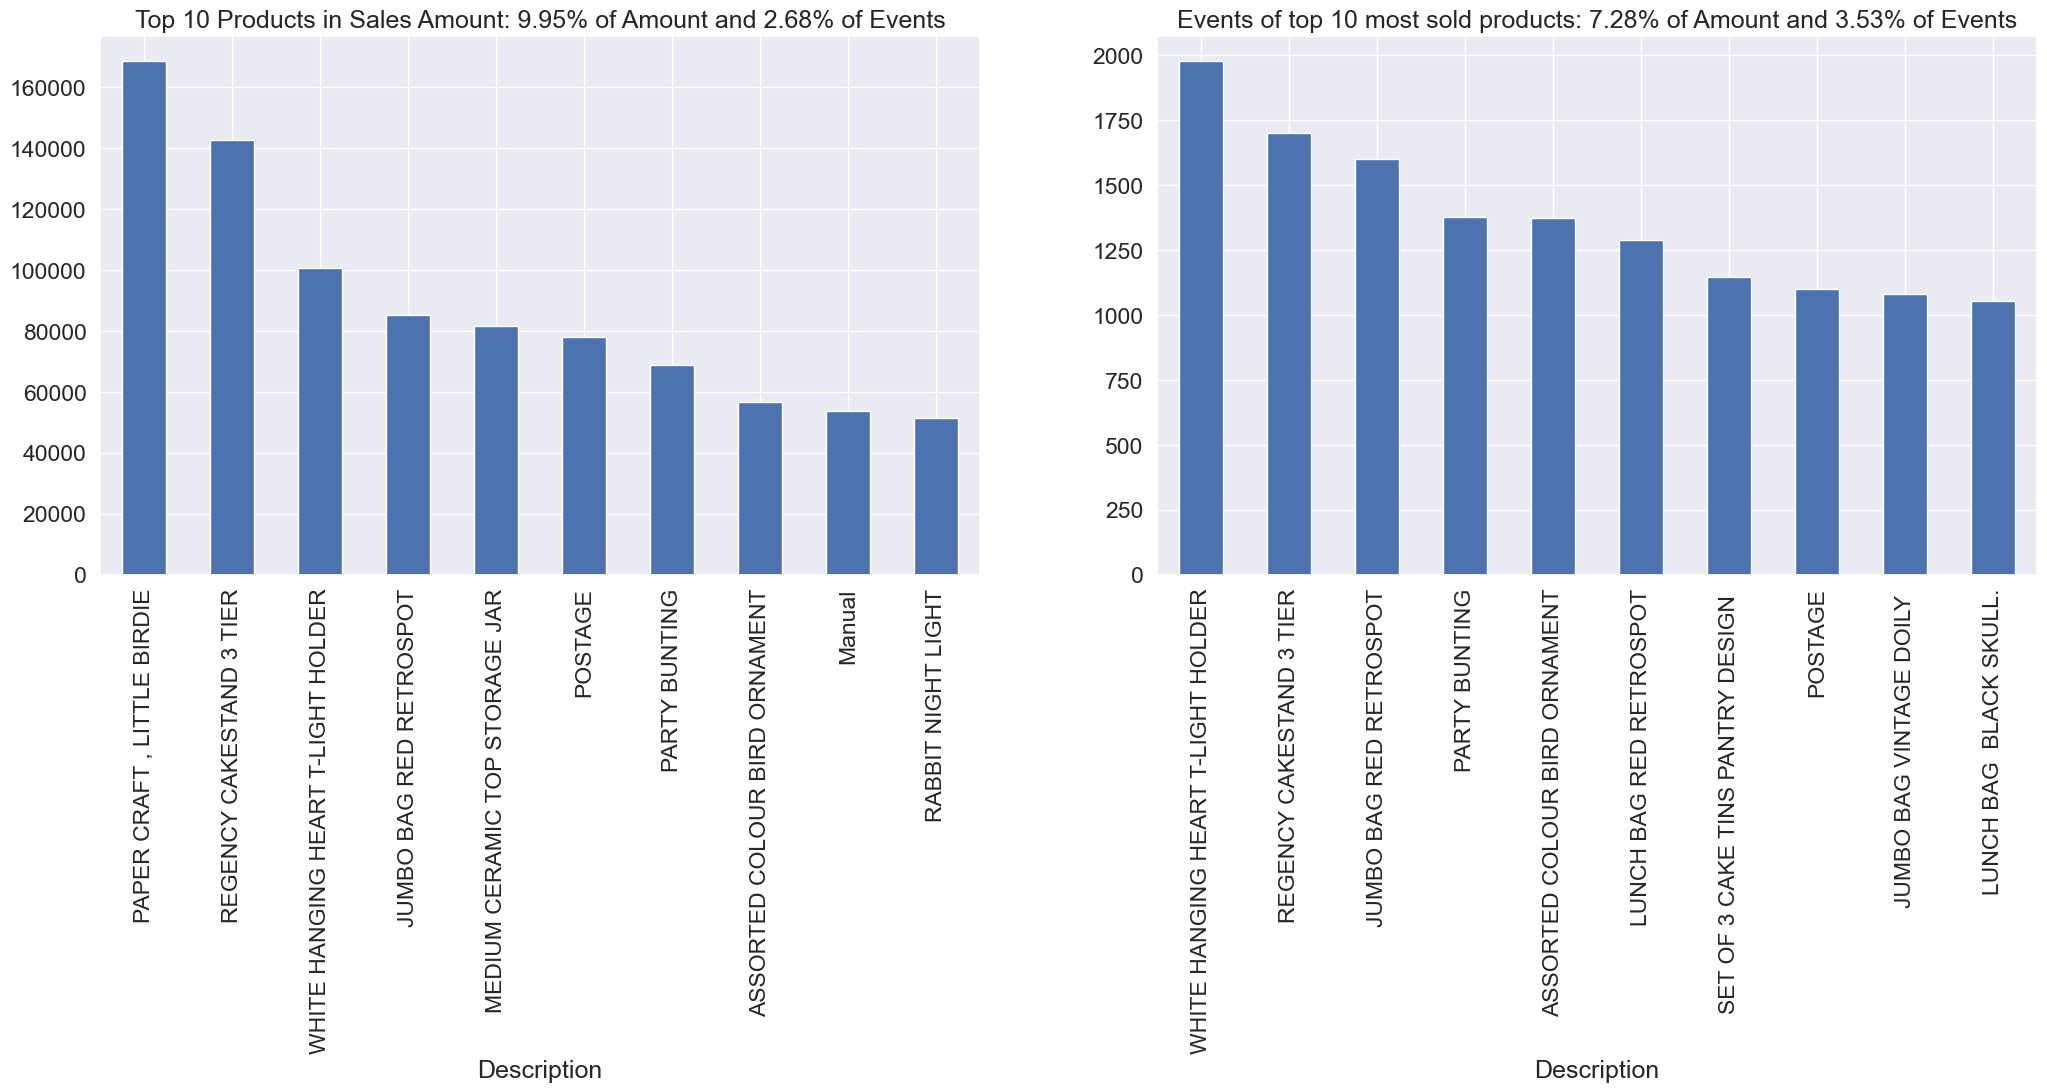

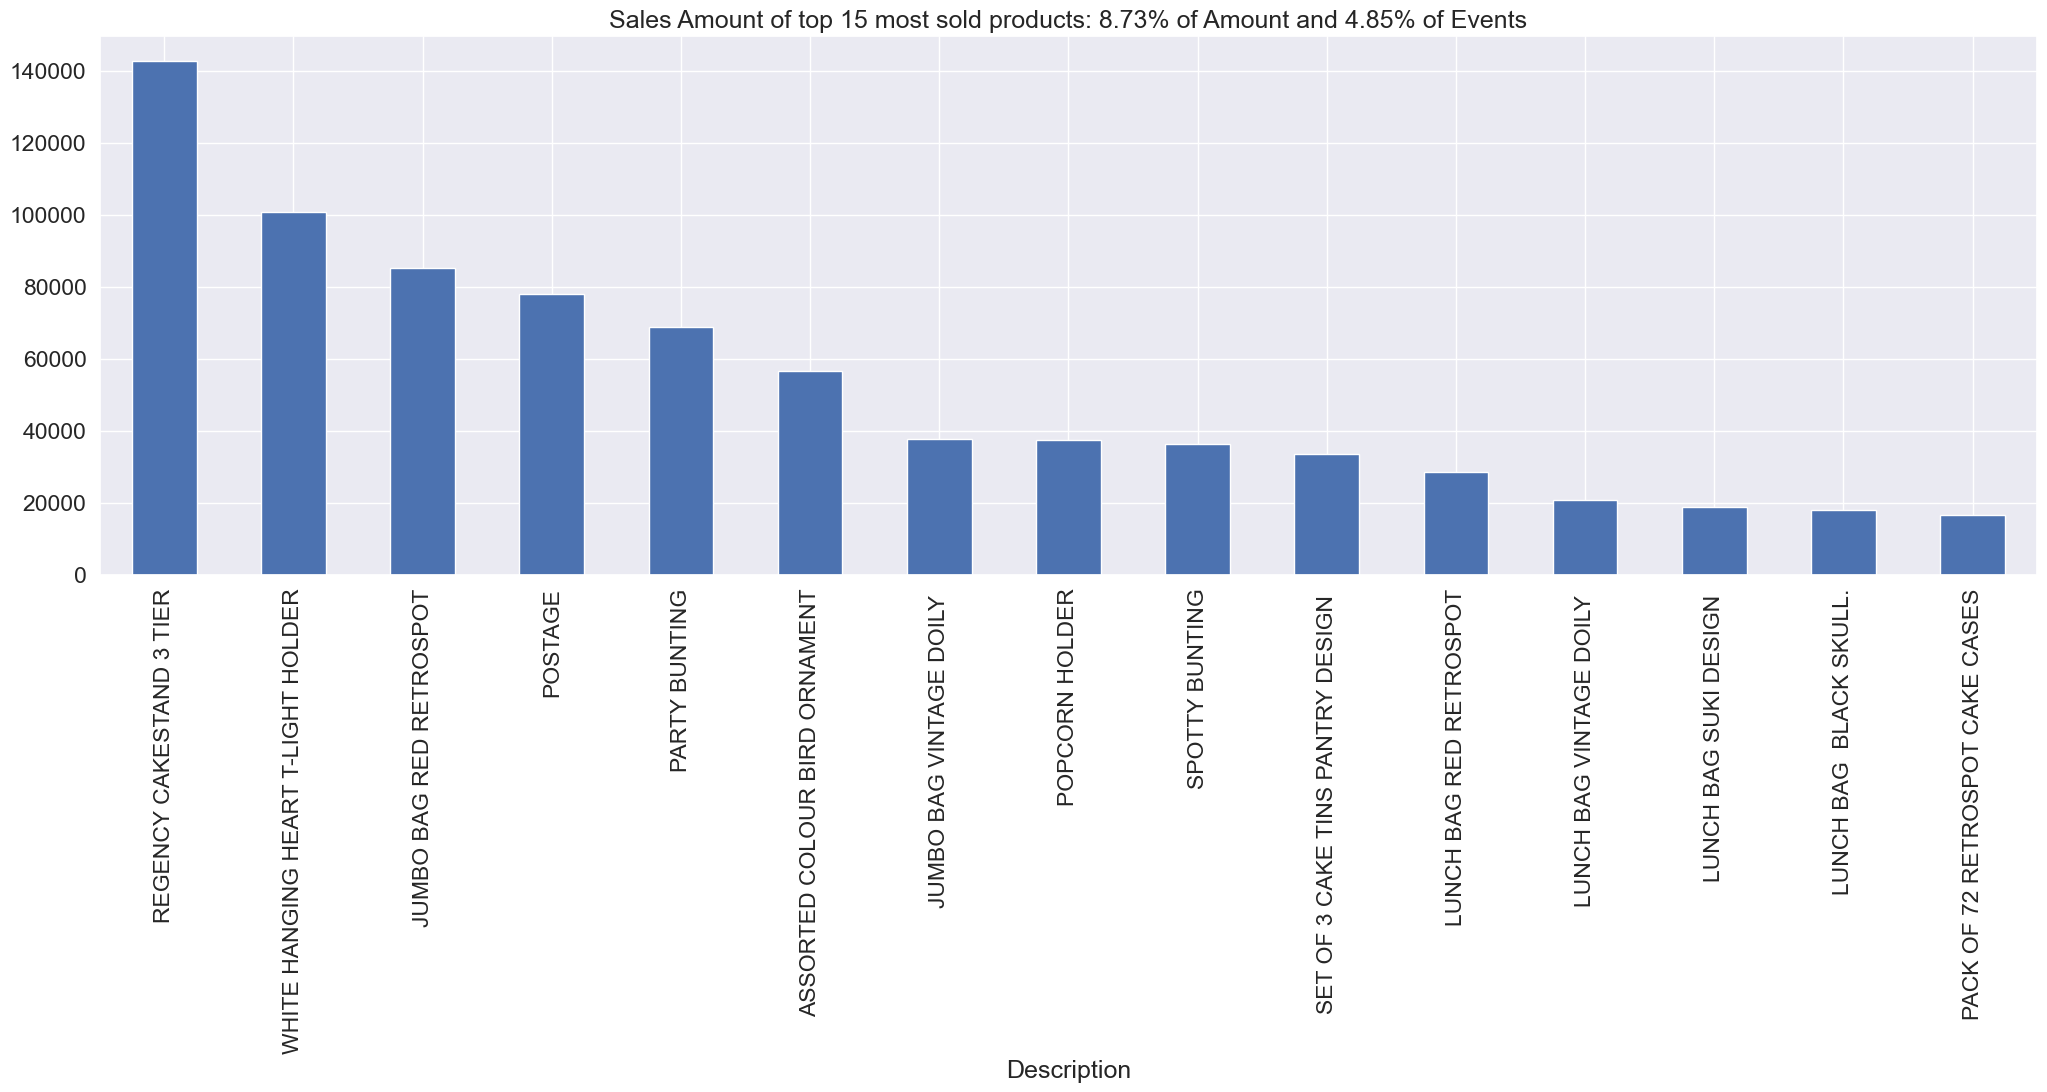

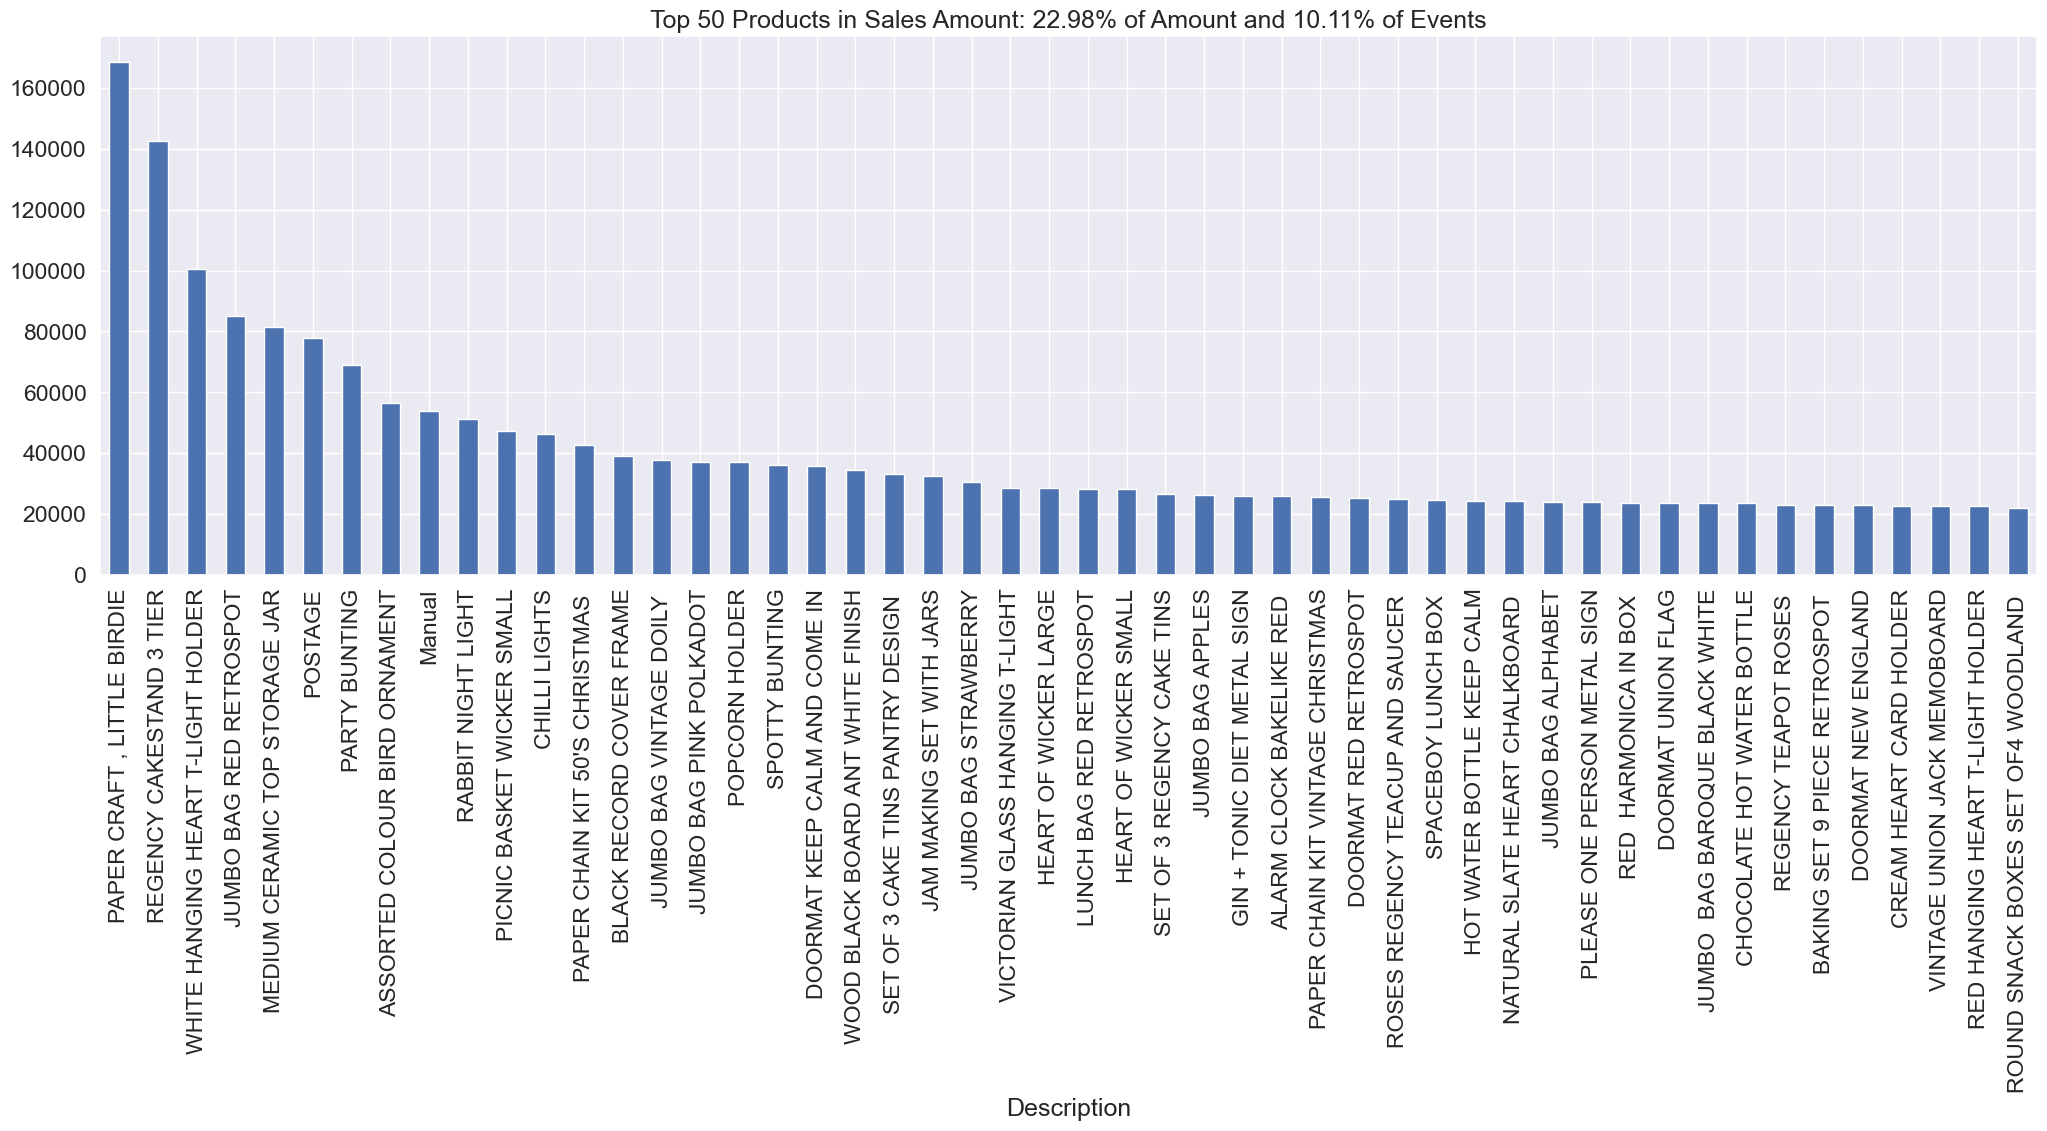

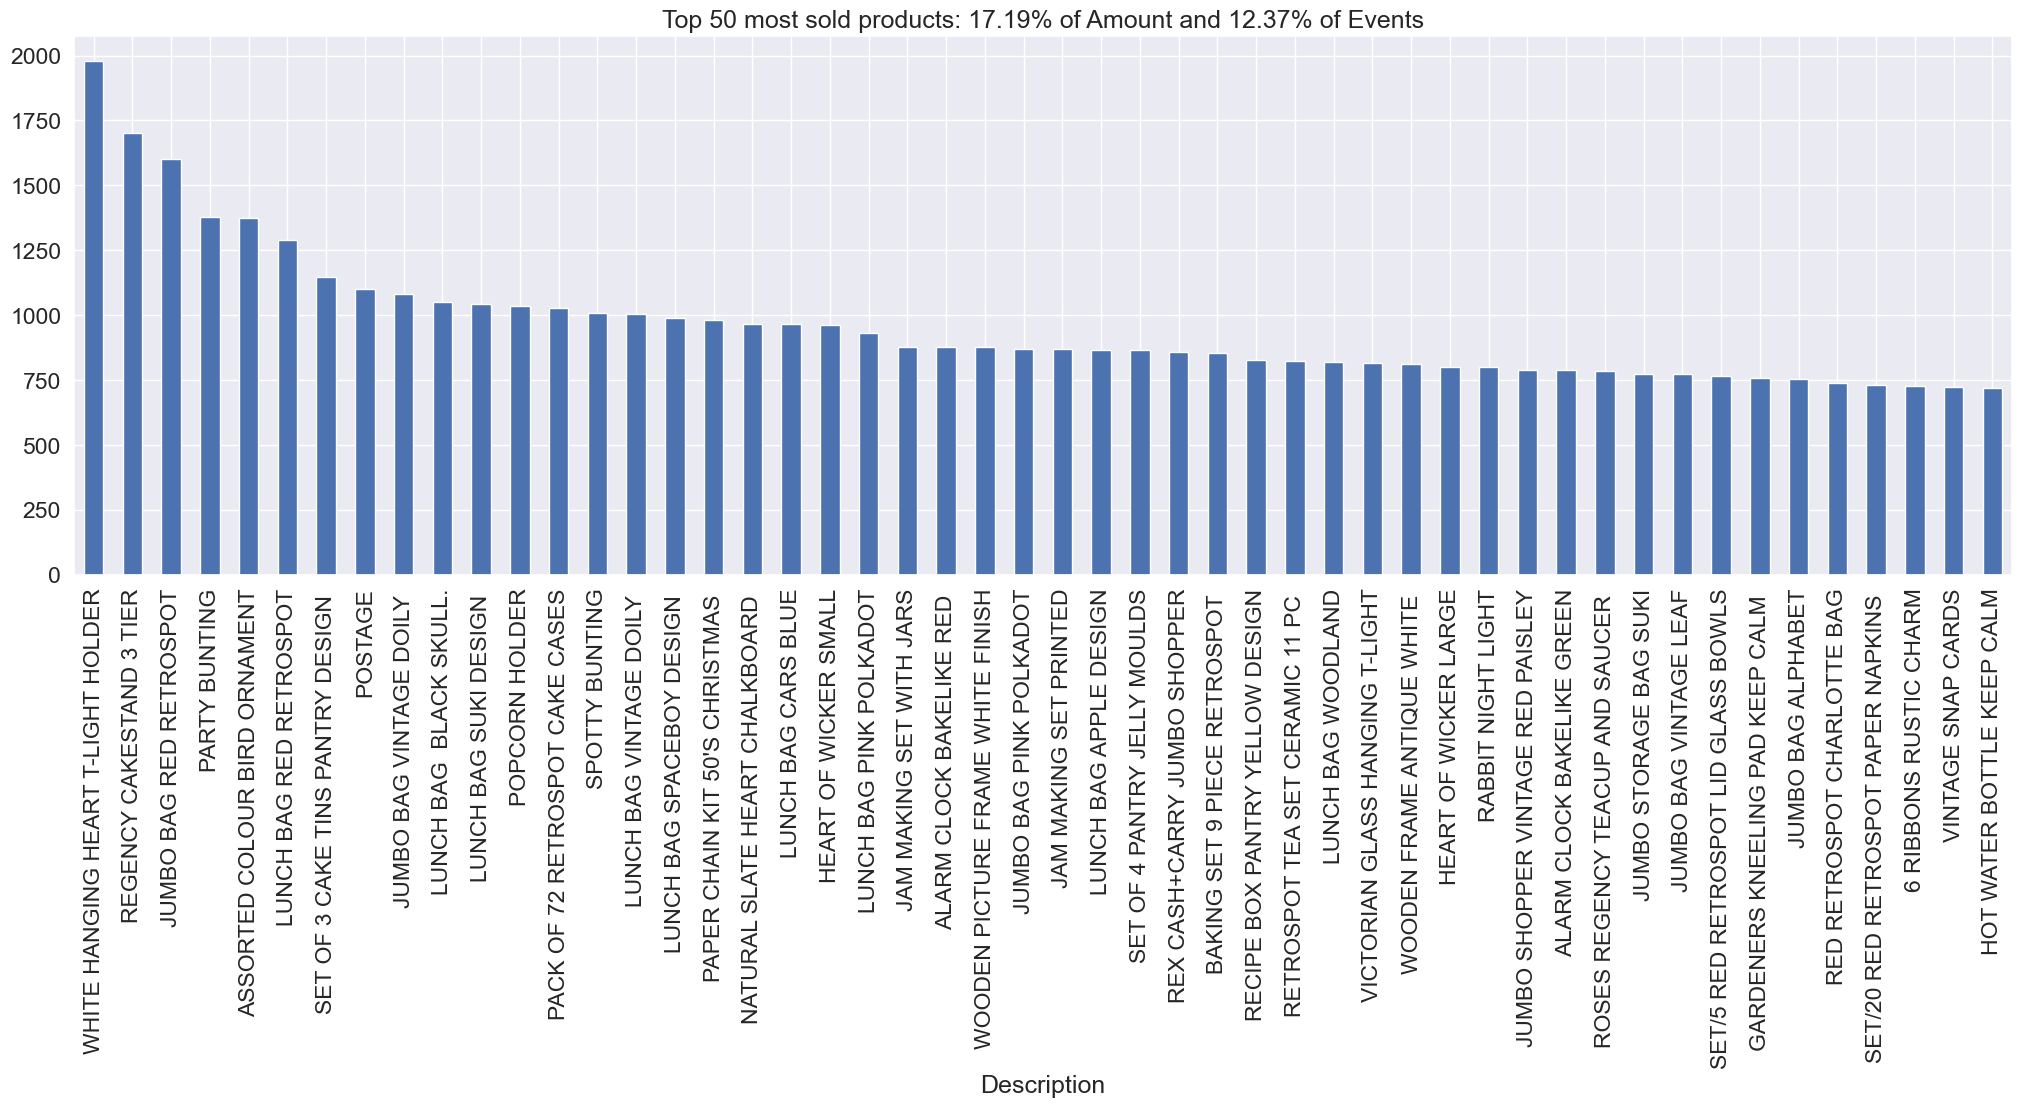

In [33]:
AmoutSum = cs_df.groupby(["Description"]).amount.sum().sort_values(ascending = False)
inv = cs_df[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmoutSum[:10].index)
PercentSales =  np.round((AmoutSum[Top10].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar',
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales =  np.round((AmoutSum[Top50].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top50].\
    plot(kind='bar',
         title='Top 50 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 50 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


## Customer Segmentation

### Recency

In [36]:
refrence_date = cs_df.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
# Calculate the timedelta and then extract the number of days
cs_df['days_since_last_purchase'] = (refrence_date - cs_df.InvoiceDate).dt.days
customer_history_df =  cs_df[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


count          mean          std      min       25%      50%  \
CustomerID  4338.0  15300.408022  1721.808492  12346.0  13813.25  15299.5   
recency     4338.0     92.536422   100.014169      1.0      18.0     51.0   

                 75%      max  
CustomerID  16778.75  18287.0  
recency        142.0    374.0

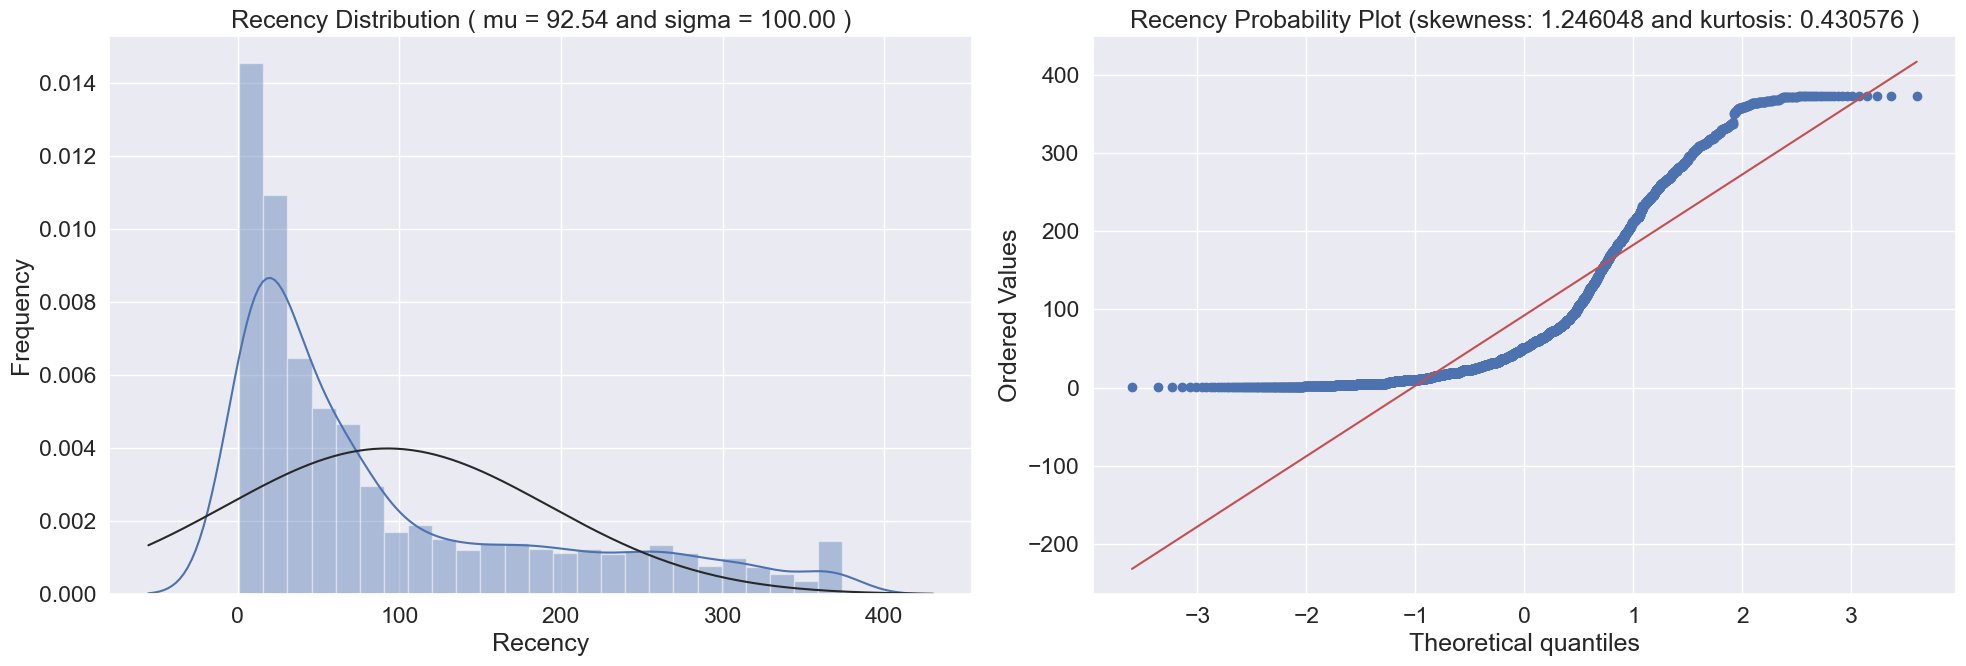

In [37]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')

### Frequency

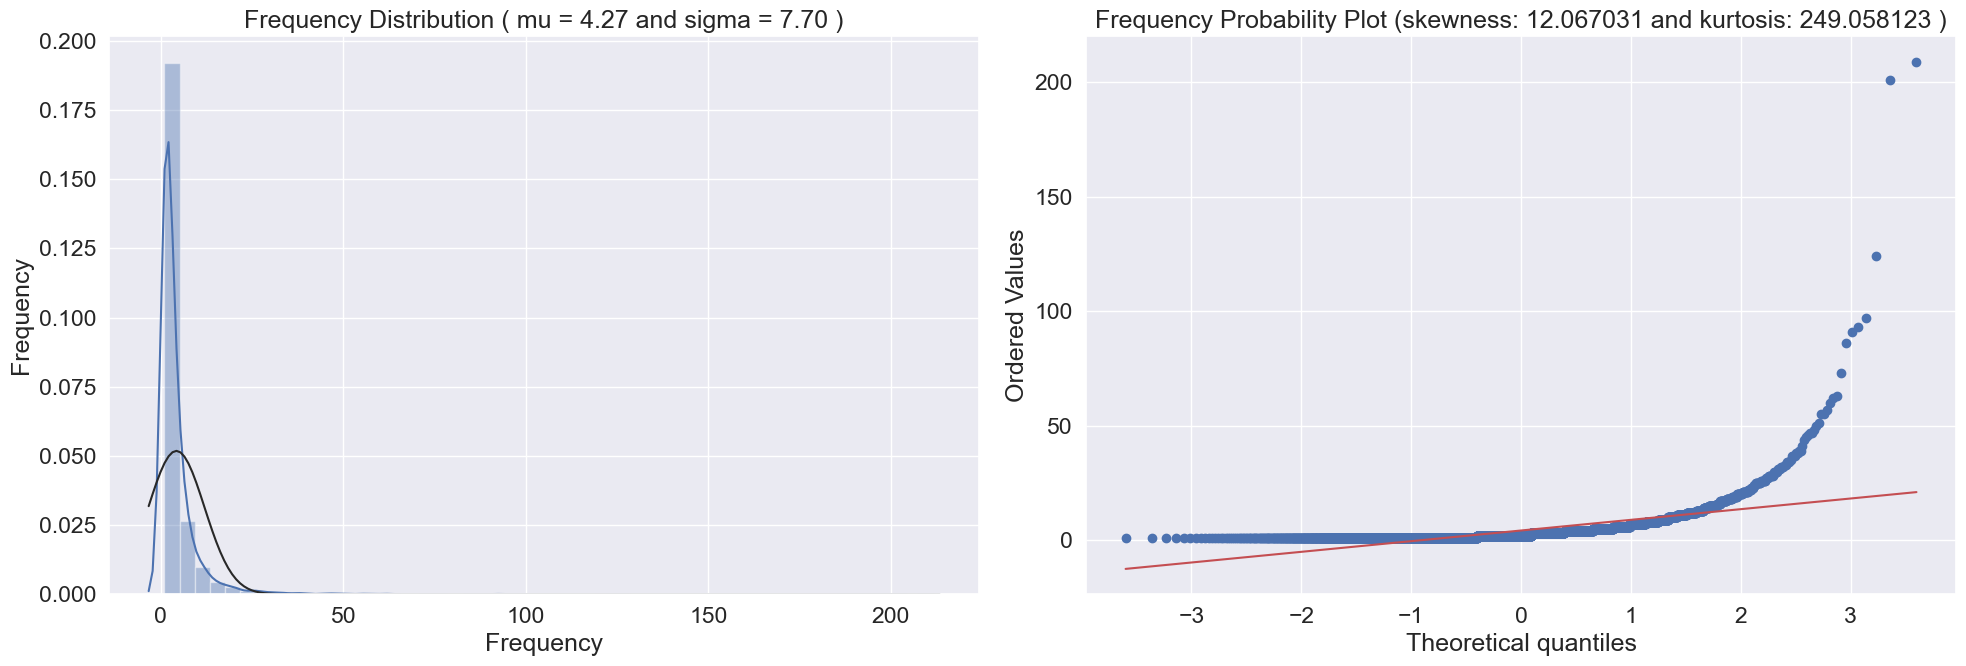

In [42]:
customer_freq = (cs_df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

### Monetary Value

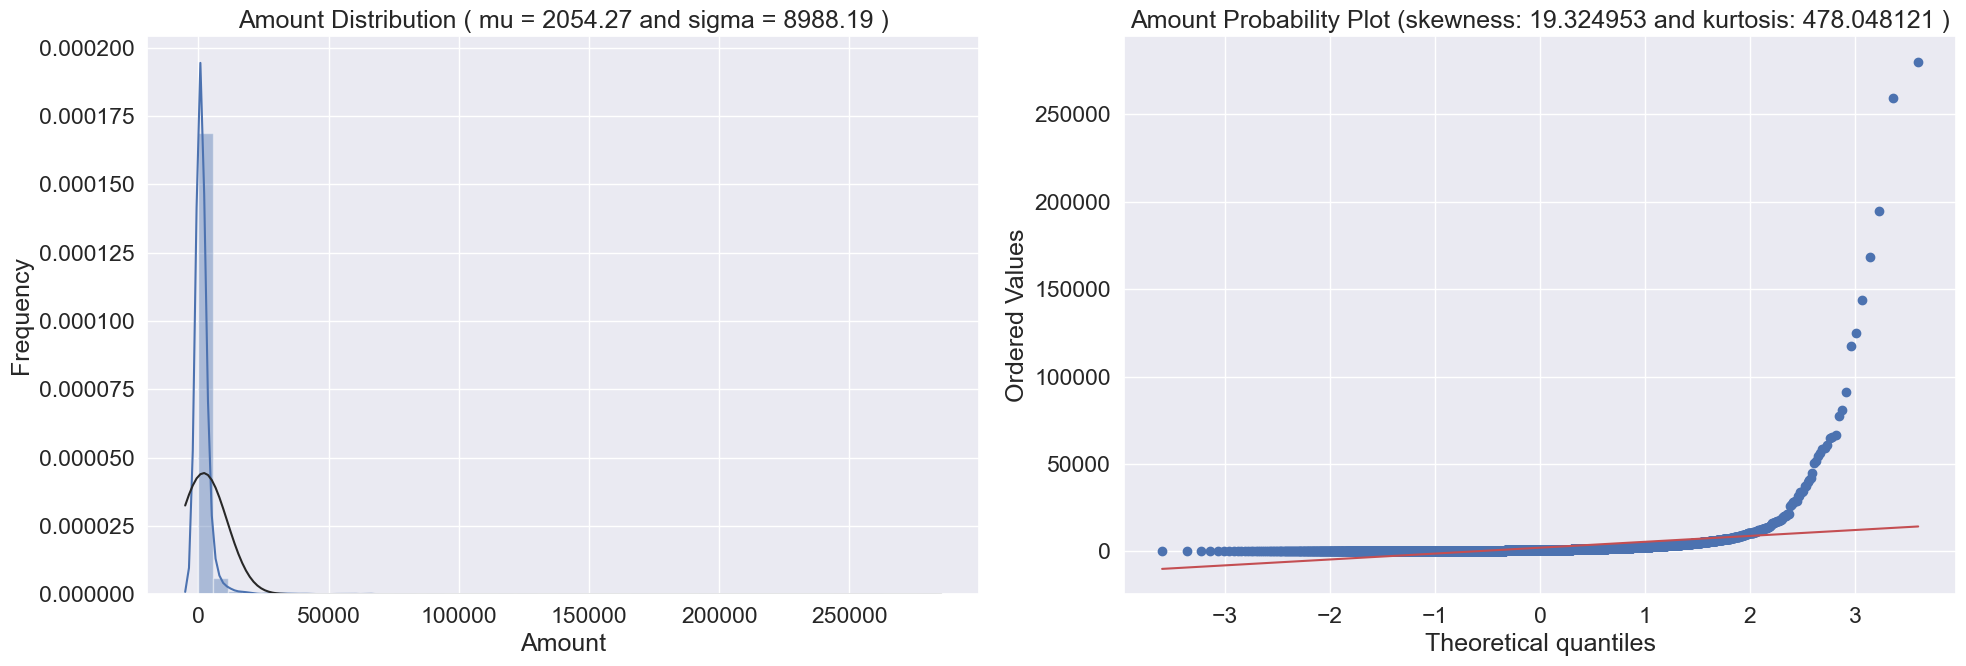

In [45]:
customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df.amount, 'Amount')

In [47]:
customer_history_df.describe()

CustomerID      recency    frequency         amount
count        4338.0  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min         12346.0     1.000000     1.000000       3.750000
25%        13813.25    18.000000     1.000000     307.415000
50%         15299.5    51.000000     2.000000     674.485000
75%        16778.75   142.000000     5.000000    1661.740000
max         18287.0   374.000000   209.000000  280206.020000

## Data Preprocessing

In [50]:
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

count          mean       std       min       25%       50%  \
amount_log     4338.0 -7.010426e-16  1.000115 -4.179280 -0.684183 -0.060942   
recency_log    4338.0 -1.048288e-16  1.000115 -2.630445 -0.612424  0.114707   
frequency_log  4338.0 -9.991495e-17  1.000115 -1.048610 -1.048610 -0.279044   

                    75%       max  
amount_log     0.654244  4.721395  
recency_log    0.829652  1.505796  
frequency_log  0.738267  4.882714

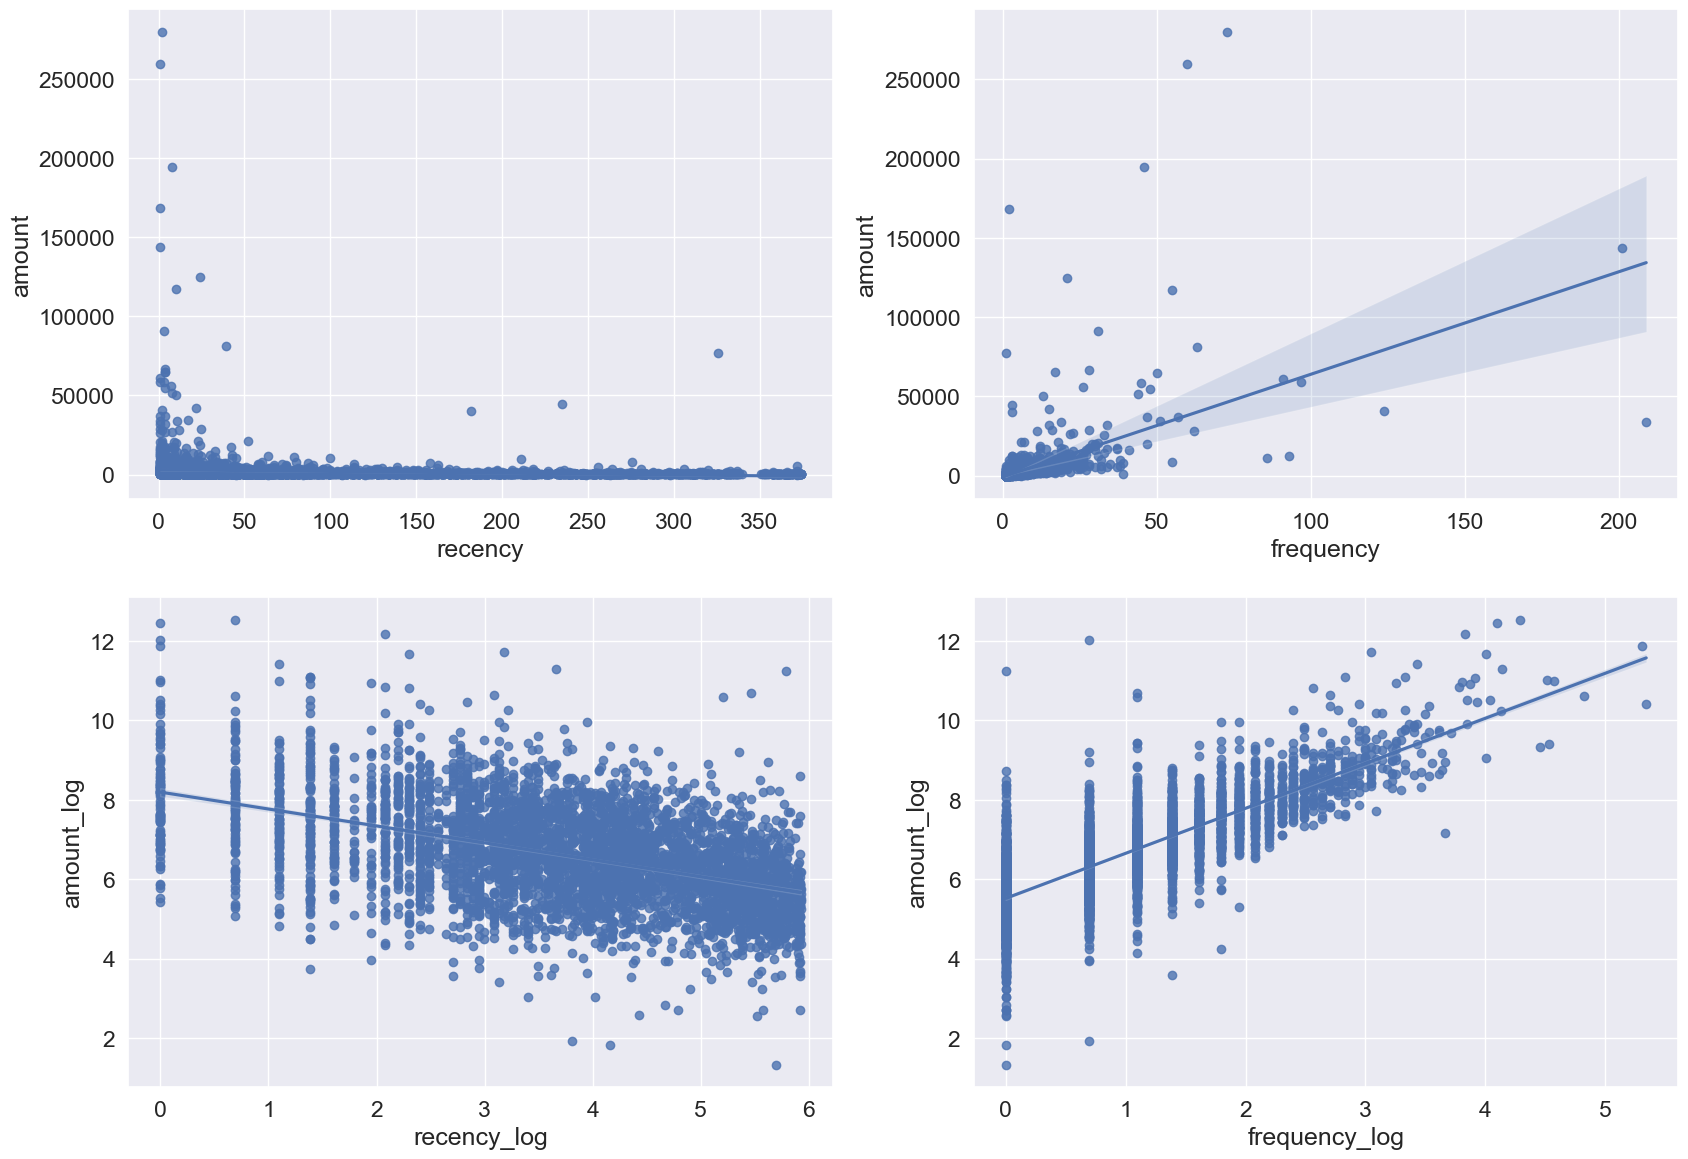

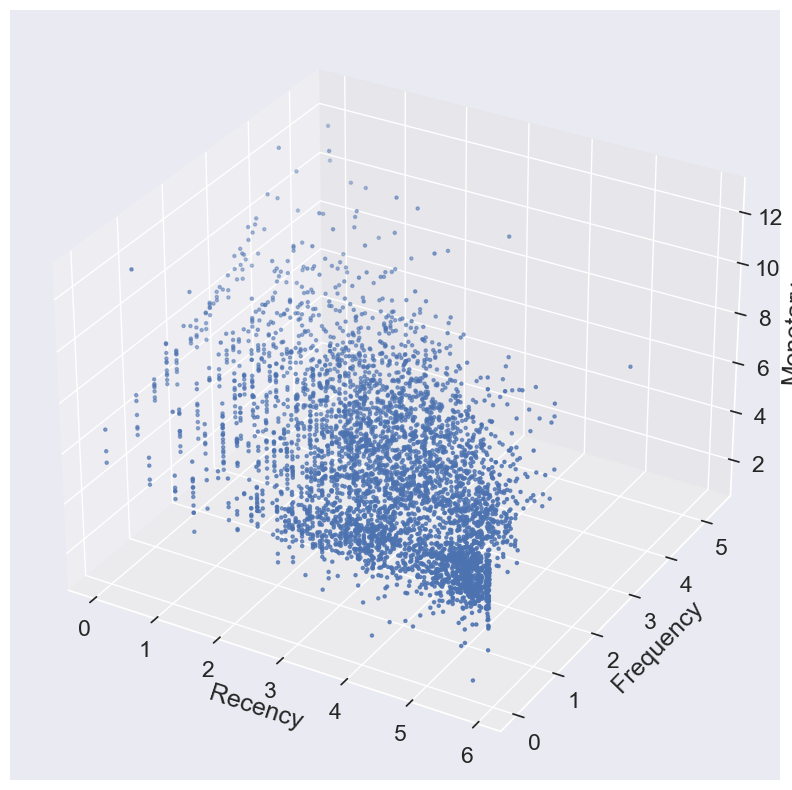

In [52]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

#Clustering for Segments
##K-Means Clustering

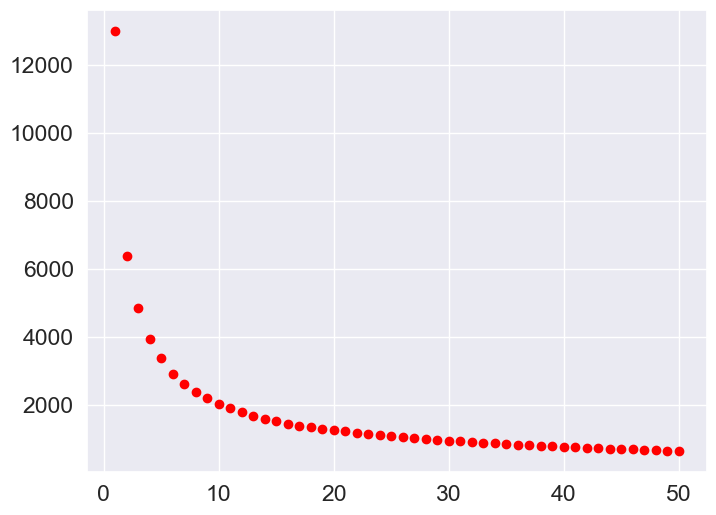

The best K sugest:  7


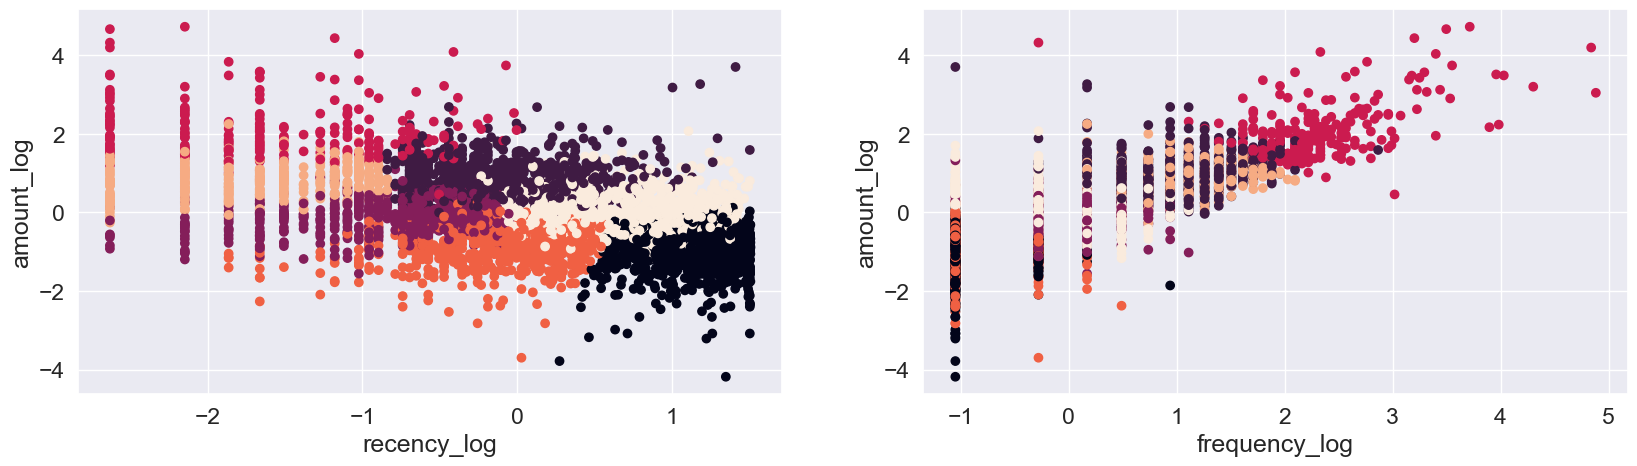

In [55]:
cl = 50
corte = 0.1

anterior = 100000000000000
cost = []
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k,
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_

    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()


##Silhouette analysis on K-Means clustering

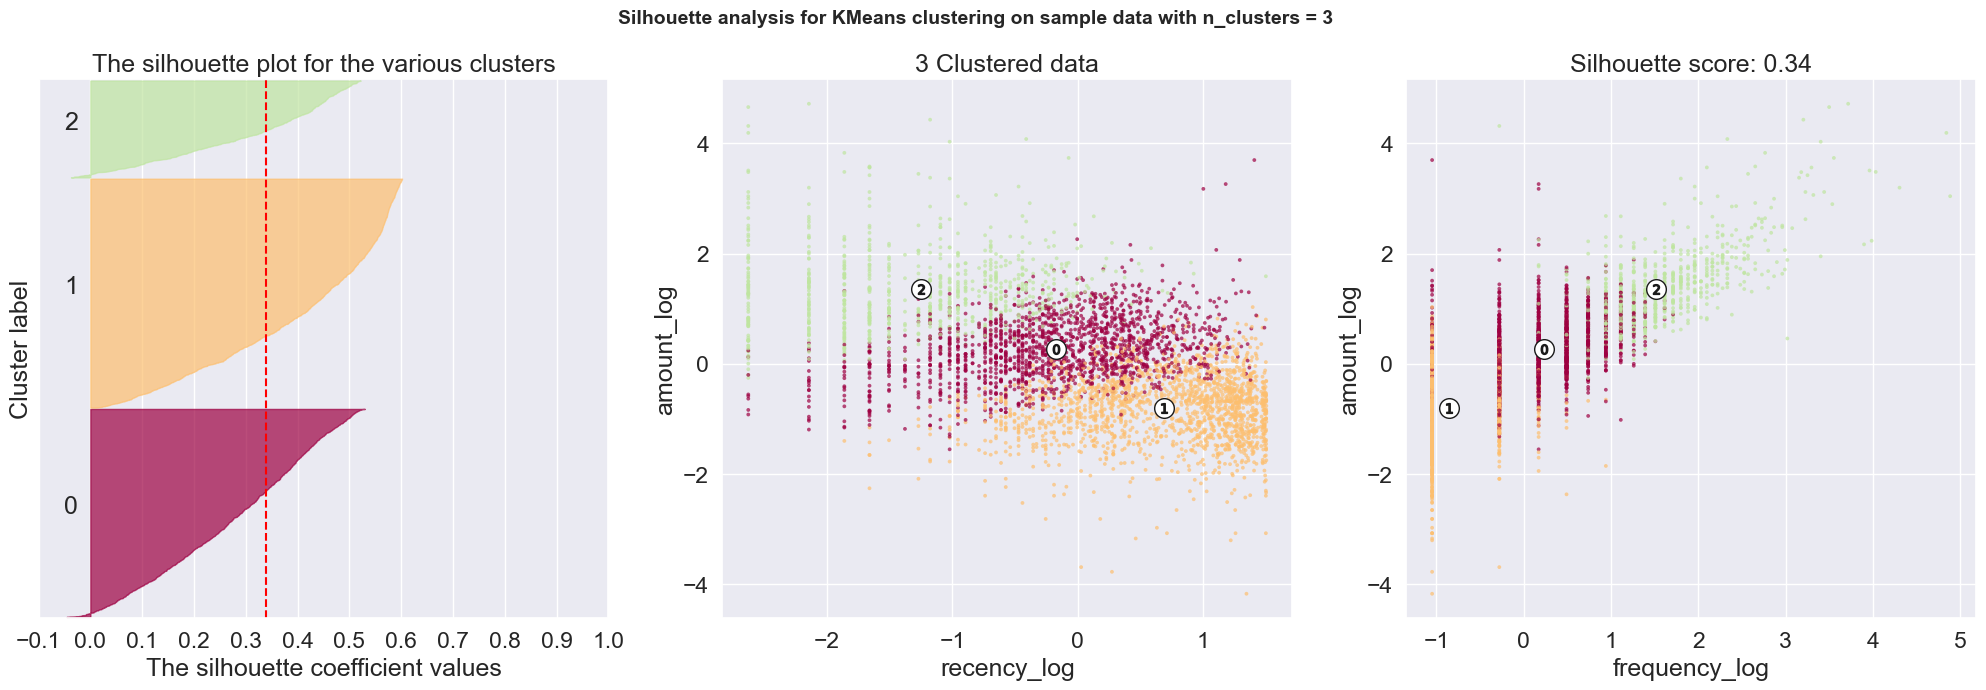

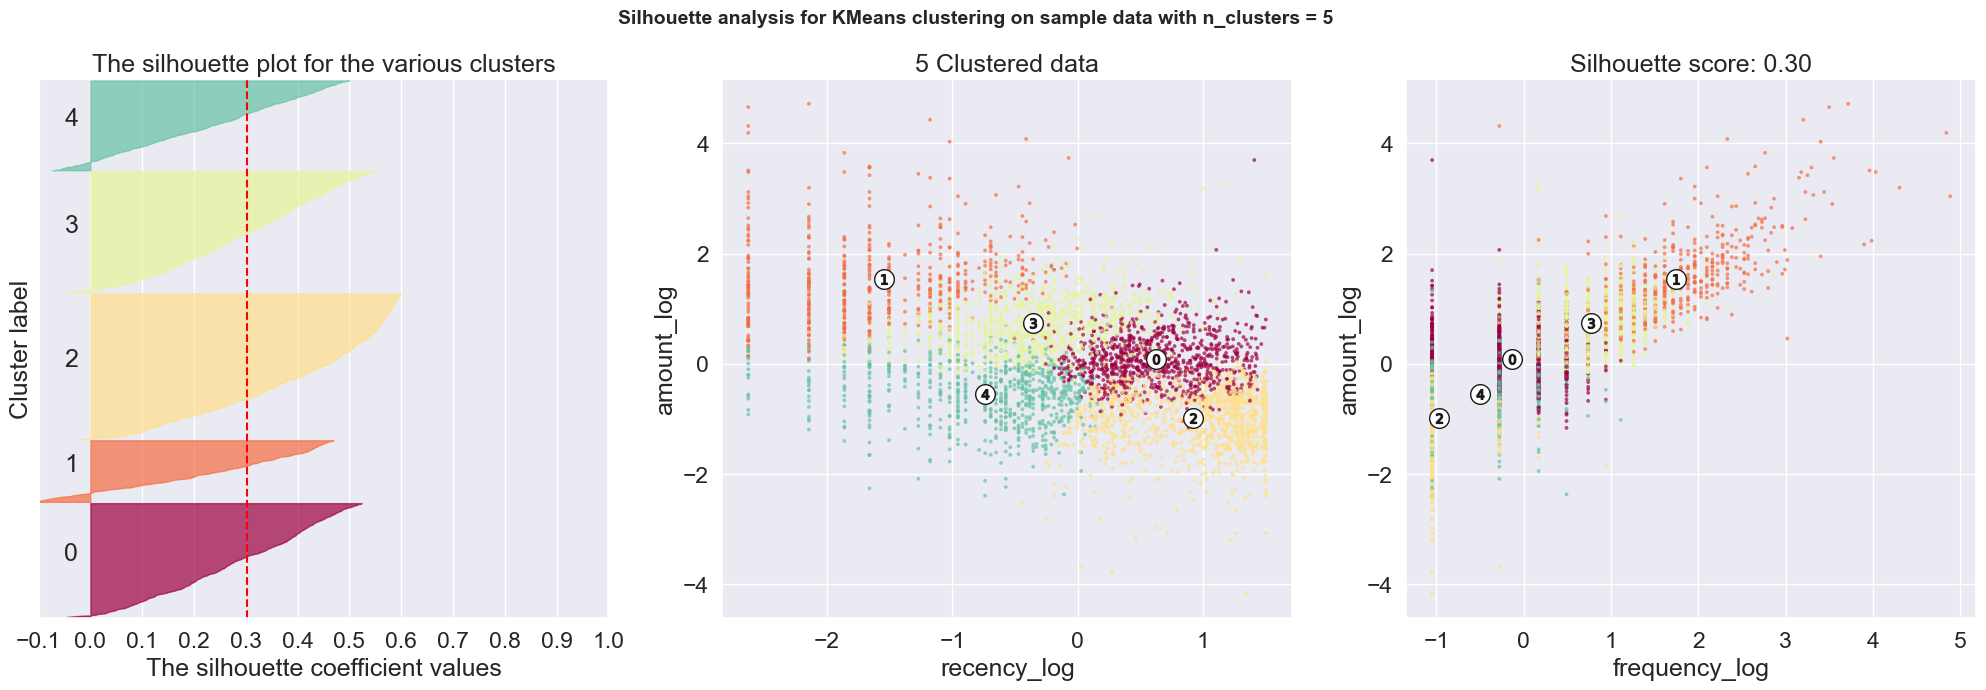

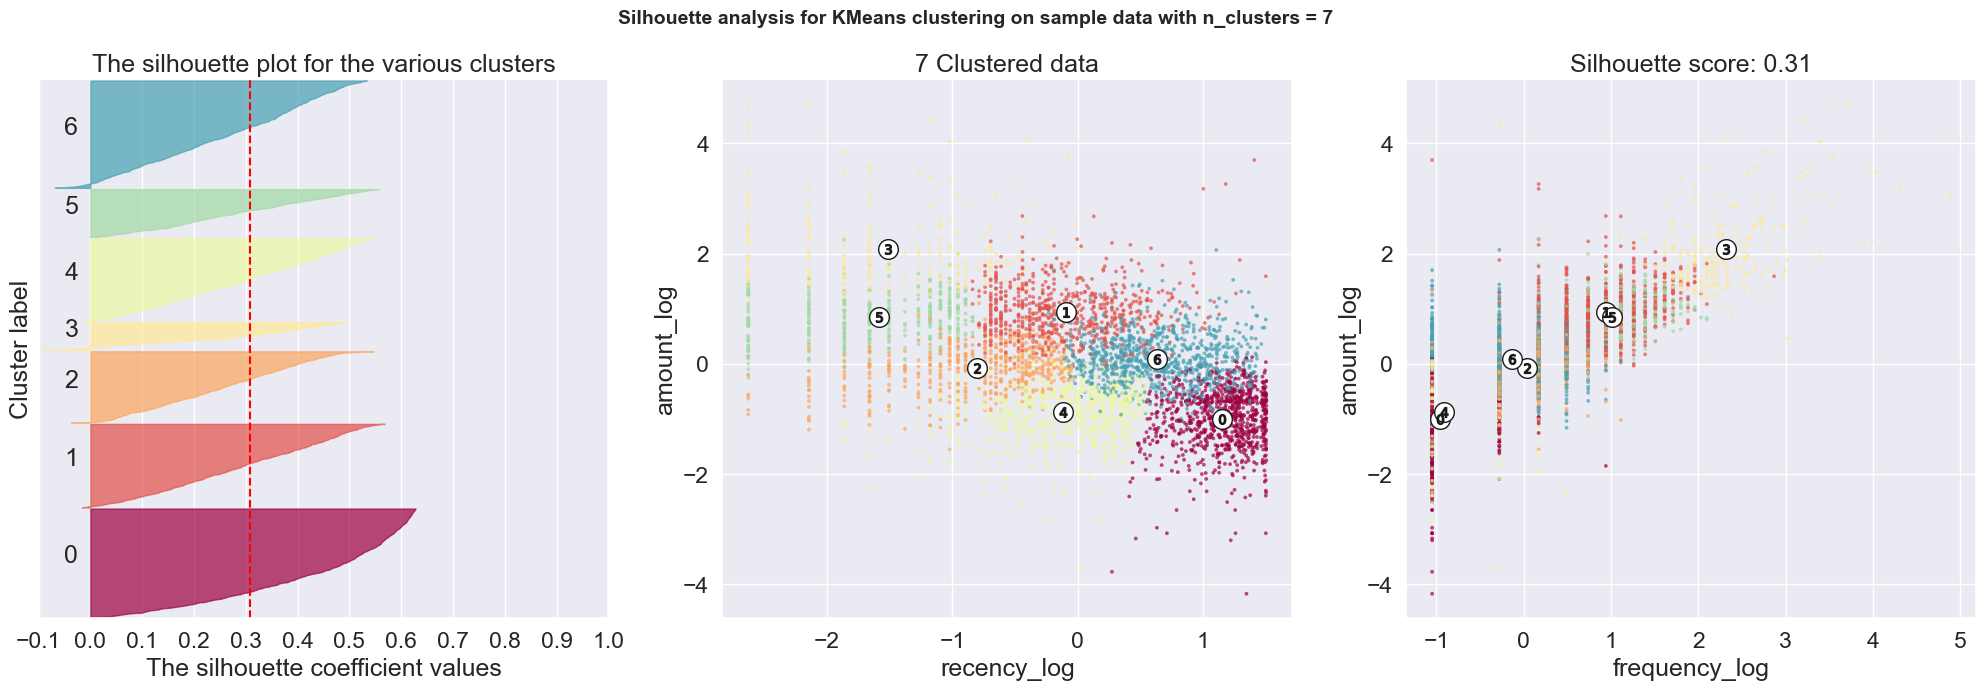

In [58]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)

    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()


##Clusters Center:
###Let's look at the cluster center values after returning them to normal values from the log and scaled version.

In [60]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
        amount     recency  frequency
0  1019.114007   33.637514   3.171771
1   262.853859  115.772727   1.196009
2  3983.322212    7.173427  10.099071
--------------------------------------------------
for 5 clusters the silhouette score is 0.30
Centers of each cluster:
        amount     recency  frequency
0   813.621211  105.524342   2.279822
1  5051.937209    4.728829  12.403678
2   208.013492  162.151056   1.075721
3  1830.850445   25.873099   5.126046
4   366.981282   15.050233   1.644625
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
         amount     recency  frequency
0    205.487848  225.646442   1.084052
1   2401.476039   37.751906   6.002805
2    657.936736   13.675696   2.647270
3  10143.118638    4.926439  20.646017
4    239.411000   36.717710   1.130641
5   2114.266897    4.458579   6.365225
6    814.574493  107.556965   2.277767

##Clusters Insights:

CustomerID  recency  frequency    amount  recency_log  frequency_log  \
0       12346      326          1  77183.60     5.786897       0.000000   
1       12347        2          7   4310.00     0.693147       1.945910   
2       12348       75          4   1797.24     4.317488       1.386294   
3       12349       19          1   1757.55     2.944439       0.000000   
4       12350      310          1    334.40     5.736572       0.000000   

   amount_log  clusters_3  clusters_5  clusters_7  
0   11.253942           0           0           1  
1    8.368693           2           1           5  
2    7.494007           0           3           1  
3    7.471676           0           4           2  
4    5.812338           1           2           0

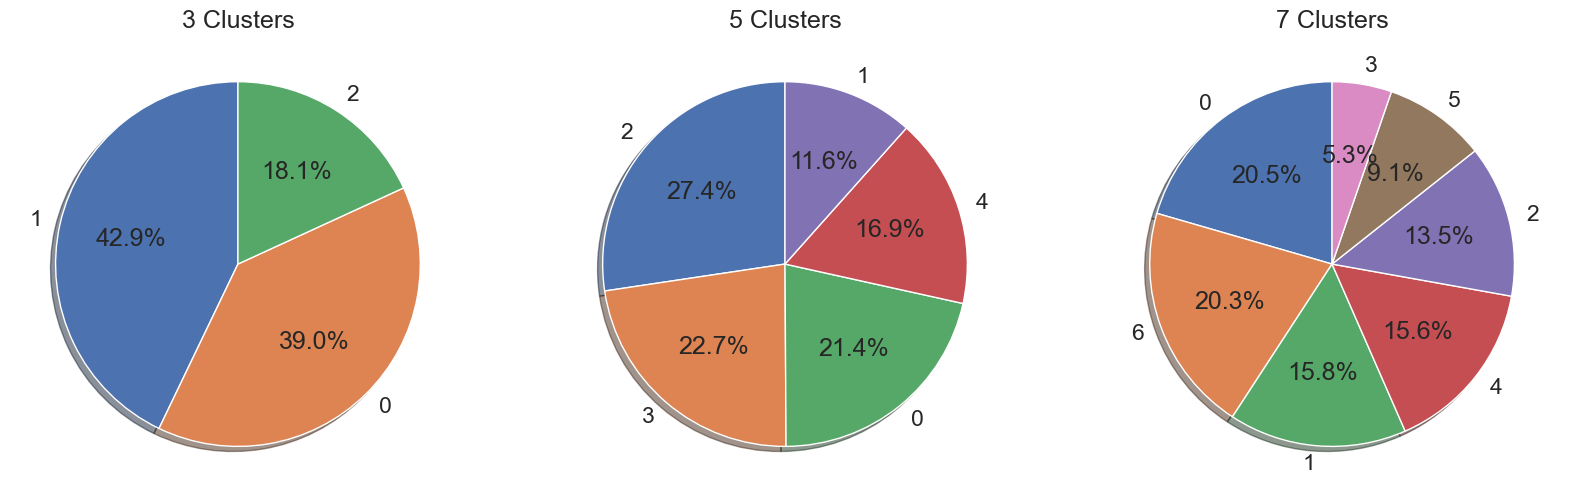

In [64]:
customer_history_df['clusters_3'] = cluster_centers[3]['labels']
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_7'] = cluster_centers[7]['labels']
display(customer_history_df.head())

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
f1 = fig.add_subplot(133)
market = customer_history_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')
plt.show()

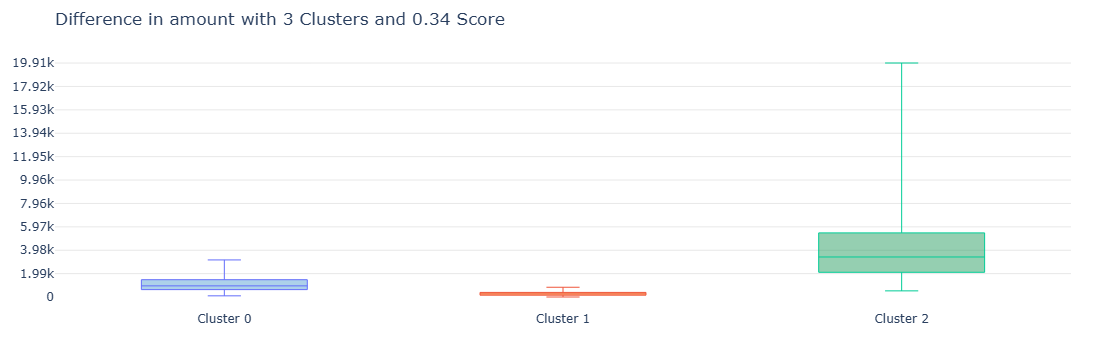

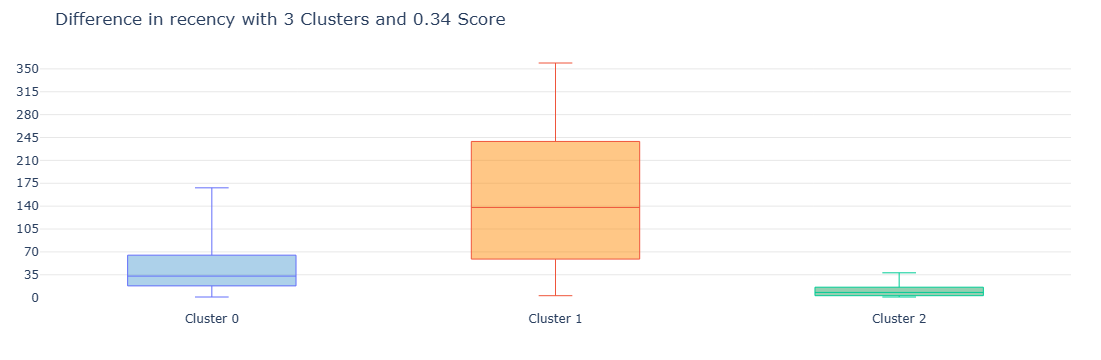

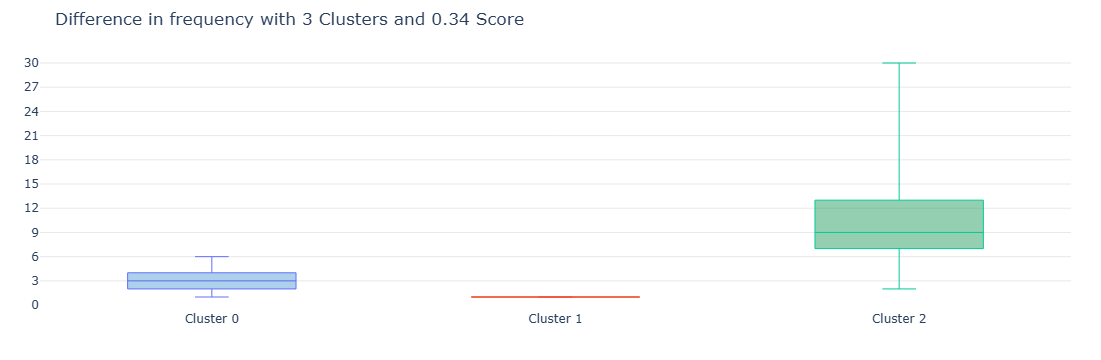

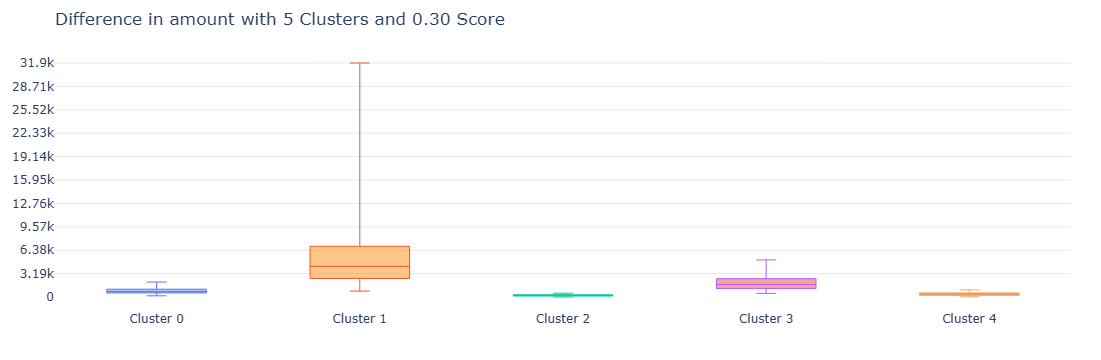

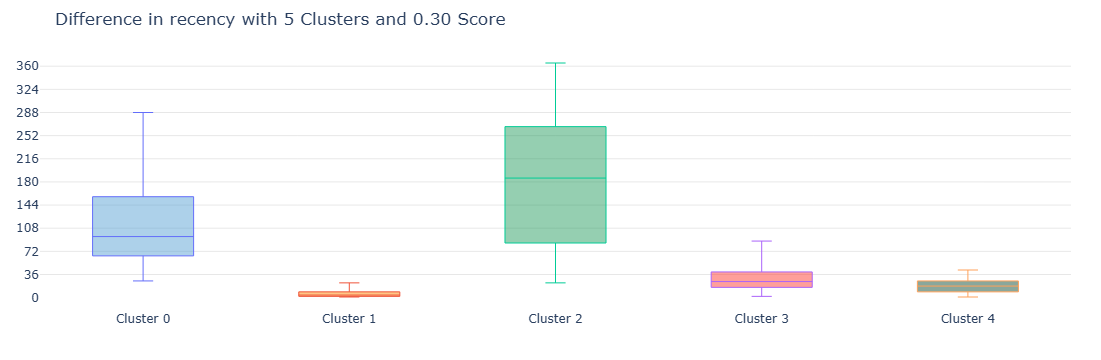

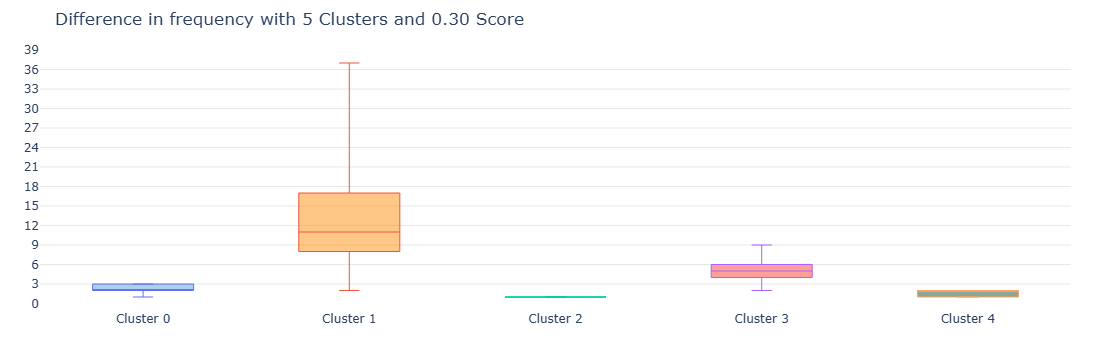

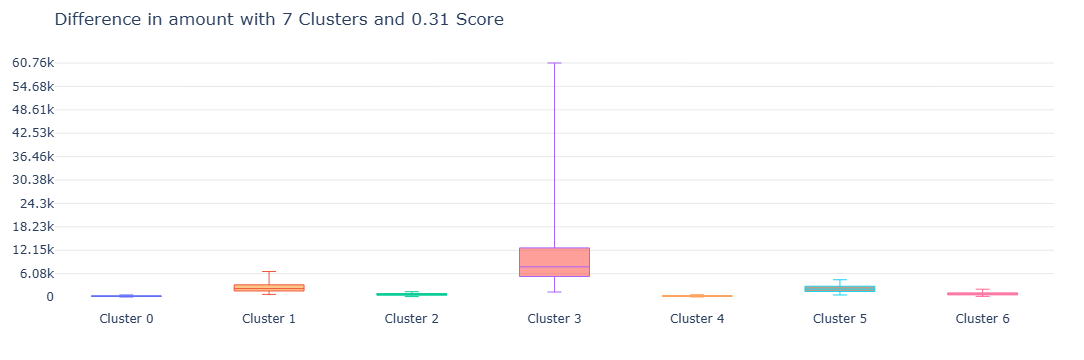

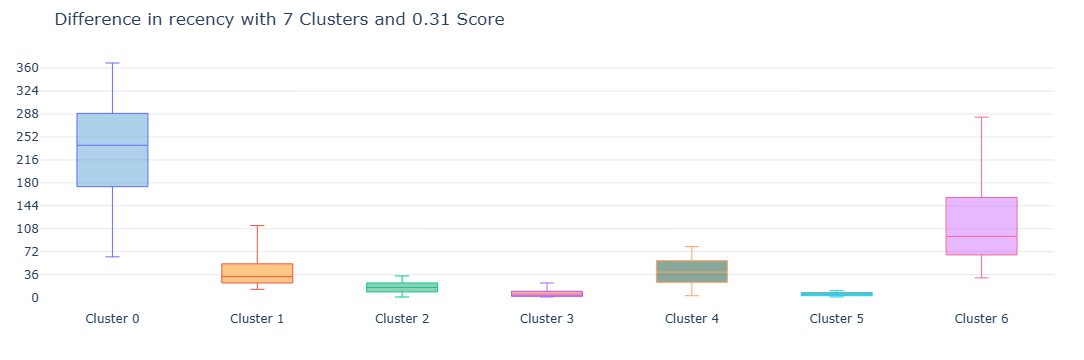

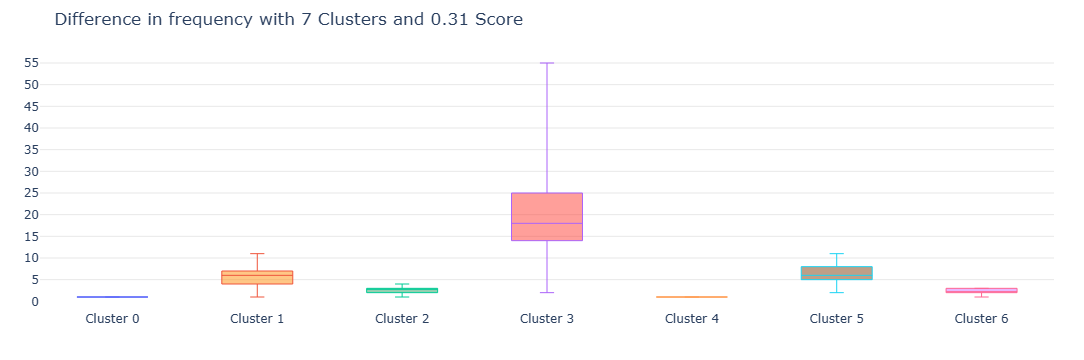

In [66]:
x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)',
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
cutoff_quantile = 95

for n_clusters in range(3,K_best+1,2):
    cl = 'clusters_' + str(n_clusters)
    for fild in range(0, 3):
        field_to_plot = features[fild]
        y_data = list()
        ymax = 0
        for i in np.arange(0,n_clusters):
            y0 = customer_history_df[customer_history_df[cl]==i][field_to_plot].values
            y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
            if ymax < max(y0): ymax = max(y0)
            y_data.insert(i, y0)

        traces = []

        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
                traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                    marker=dict( size=1, ),
                    line=dict(width=1),
                ))

        layout = go.Layout(
            title='Difference in {} with {} Clusters and {:1.2f} Score'.\
            format(field_to_plot, n_clusters, cluster_centers[n_clusters]['silhouette_score']),
            yaxis=dict( autorange=True, showgrid=True, zeroline=True,
                dtick = int(ymax/10),
                gridcolor='black', gridwidth=0.1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2, ),
            margin=dict(l=40, r=30, b=50, t=50, ),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        fig = go.Figure(data=traces, layout=layout)
        py.offline.iplot(fig)

In [ ]:
### Cross Selling

In [ ]:
#This will generate a sparse table

In [69]:
items = list(cs_df.Description.unique())
grouped = cs_df.groupby('InvoiceNo')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)

In [71]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, 
                  start_item = None, end_item = None, TopCols = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',
                               item_count.columns[1]:'item_count'}, inplace=True)
    if TopCols: 
        input_df['total_items'] = input_df[TopCols].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[TopCols], item_count[item_count.item_name.isin(TopCols)]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]
    else:
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]


In [73]:
output_df, item_counts = prune_dataset(input_df=transaction_df, length_trans=2,start_item = 0, end_item = 15)
print('Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): {:.2f}'.format(AmoutSum[Top15ev].sum()))
print('Number of Sales Events:', output_df.shape[0])
print('Number of Products:', output_df.shape[1])

item_counts

Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): 778377.21
Number of Sales Events: 4664
Number of Products: 15


item_name  item_count
0   WHITE HANGING HEART T-LIGHT HOLDER        1978
1             REGENCY CAKESTAND 3 TIER        1703
2              JUMBO BAG RED RETROSPOT        1600
3                        PARTY BUNTING        1379
4        ASSORTED COLOUR BIRD ORNAMENT        1375
5              LUNCH BAG RED RETROSPOT        1289
6    SET OF 3 CAKE TINS PANTRY DESIGN         1146
7                              POSTAGE        1099
8             JUMBO BAG VINTAGE DOILY         1080
9              LUNCH BAG  BLACK SKULL.        1052
10              LUNCH BAG SUKI DESIGN         1043
11                      POPCORN HOLDER        1035
12     PACK OF 72 RETROSPOT CAKE CASES        1029
13                      SPOTTY BUNTING        1009
14            LUNCH BAG VINTAGE DOILY         1006

In [77]:
# Defined the data domain by specifying each variable as a DiscreteVariable having values as (0, 1)
domain_transac = Domain([DiscreteVariable.make(name=item, values=['0', '1']) \
                         for item in input_assoc_rules.columns])

# Using .values instead of .as_matrix() to create the Table structure for the data
data_tran = Orange.data.Table.from_numpy(domain=domain_transac,  
                                         X=input_assoc_rules.values, Y=None)

# Coding the input so that the entire domain is represented as binary variables
data_tran_en, mapping = OneHot.encode(data_tran, include_class=True)


In [79]:
support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_en, support))
print('Items Set Size:', len(itemsets))

num of required transactions =  46
Items Set Size: 663273


In [81]:
confidence = 0.6
rules_df = pd.DataFrame()
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 25247 rules generated


In [83]:
dw = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 100
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['confidence', 'support', 'lift'],
                                                   ascending=False)).head()

consequent  \
20   JUMBO BAG VINTAGE DOILY    
131  LUNCH BAG VINTAGE DOILY    
132  LUNCH BAG VINTAGE DOILY    
129  LUNCH BAG VINTAGE DOILY    
21   JUMBO BAG VINTAGE DOILY    

                                                                                             antecedent  \
20                           JUMBO BAG RED RETROSPOT, LUNCH BAG RED RETROSPOT, LUNCH BAG VINTAGE DOILY    
131  LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG  BLACK SKULL., LUNCH BAG SUKI DESIGN    
132                           LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG SUKI DESIGN    
129                          LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG  BLACK SKULL.   
21                            JUMBO BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN , LUNCH BAG VINTAGE DOILY    

     support  confidence      lift  
20        60    0.909091  4.520256  
131       49    0.890909  4.596460  
132       48    0.888889  4.586037  
129       48    0.872727  4.502655  
21        48    0.872727  4.339446

In [85]:
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['support', 'confidence', 'lift'],
                                                   ascending=False)).head()

consequent  \
121  LUNCH BAG VINTAGE DOILY    
28   JUMBO BAG VINTAGE DOILY    
90    LUNCH BAG RED RETROSPOT   
82    LUNCH BAG RED RETROSPOT   
76    LUNCH BAG RED RETROSPOT   

                                            antecedent  support  confidence  \
121  JUMBO BAG VINTAGE DOILY , LUNCH BAG RED RETROSPOT      176    0.789238   
28   LUNCH BAG VINTAGE DOILY , JUMBO BAG RED RETROSPOT      153    0.805263   
90    LUNCH BAG VINTAGE DOILY , LUNCH BAG SUKI DESIGN       149    0.668161   
82     LUNCH BAG SUKI DESIGN , JUMBO BAG RED RETROSPOT      149    0.645022   
76     LUNCH BAG  BLACK SKULL., LUNCH BAG SUKI DESIGN       149    0.605691   

         lift  
121  4.071908  
28   4.003995  
90   2.672646  
82   2.580087  
76   2.422764

In [87]:
rules_df.lift.apply(lambda x: 'Greater Than One' if x > 1 else 'One' \
                           if x == 0 else 'Less Than One').value_counts()

lift
Greater Than One    25247
Name: count, dtype: int64